# Snapping points to lines and identifying streets with the most street flooding complaints

Mark Bauer

In [1607]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

In [1608]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [1609]:
%watermark -v -p numpy,pandas,geopandas,matplotlib.pyplot,matplotlib,seaborn,fiona,contextily

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
matplotlib.pyplot 3.3.2
matplotlib 3.3.2
seaborn 0.11.1
fiona 1.8.13.post1
contextily 1.0.0


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [1610]:
# list items in data folder
%ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [1611]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw_street_flooding_complaints.csv')

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27428, 34)


/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
1    38610039  2018-03-04T06:10:00.000  2018-03-07T10:00:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11210.0                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)       10304.0                   NaN   
3  Street Flooding (SJ)       11416.0                   NaN   
4  Street Flooding (SJ)       11357.0                 6 AVE   

  intersection_street_2  ...  longitude  \
0                   NaN  ... -73.954072   
1          ATLANTIC AVE  ...        NaN   
2                   NaN  ... -74.099007   
3                   NaN  ... -73.842086   
4       CLINTONVILLE ST  ... -73.814709   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
1                                                NaN               NaN   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   

  street_name cross_street_1    cross_street_2           bbl due_date  \
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN      NaN   
1         NaN       ESSEX ST      ATLANTIC AVE           NaN      NaN   
2  MEDFORD RD       KEUNE CT         FOREST RD  5.008420e+09      NaN   
3      102 ST         95 AVE            97 AVE  4.093790e+09      NaN   
4         NaN          6 AVE   CLINTONVILLE ST           NaN      NaN   

   location_type  landmark  
0            NaN       NaN  
1            NaN       NaN  
2            NaN       NaN  
3            NaN       NaN  
4            NaN       NaN  

[5 rows x 34 columns]

In [1612]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27423    36899327  2017-08-08T14:46:00.000  2017-09-10T09:30:00.000    DEP   
27424    36903138  2017-08-09T10:09:00.000  2017-08-09T11:00:00.000    DEP   
27425    36974378  2017-08-18T11:25:00.000  2017-08-18T14:20:00.000    DEP   
27426    36979728  2017-08-18T16:26:00.000  2017-08-18T18:20:00.000    DEP   
27427    36984240  2017-08-19T15:39:00.000  2017-08-20T08:05:00.000    DEP   

                                  agency_name complaint_type  \
27423  Department of Environmental Protection          Sewer   
27424  Department of Environmental Protection          Sewer   
27425  Department of Environmental Protection          Sewer   
27426  Department of Environmental Protection          Sewer   
27427  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
27423  Street Flooding (SJ)           NaN             COLFAX ST   
27424  Street Flooding (SJ)           NaN                   NaN   
27425  Street Flooding (SJ)           NaN                   NaN   
27426  Street Flooding (SJ)           NaN                   NaN   
27427  Street Flooding (SJ)           NaN           BEACH 84 ST   

      intersection_street_2  ... longitude location  incident_address  \
27423                212 ST  ...       NaN      NaN               NaN   
27424                   NaN  ...       NaN      NaN     FLATLANDS AVE   
27425                   NaN  ...       NaN      NaN         LINDEN PL   
27426                   NaN  ...       NaN      NaN             1 AVE   
27427         ROCKAWAY FRWY  ...       NaN      NaN               NaN   

         street_name  cross_street_1   cross_street_2 bbl due_date  \
27423            NaN       COLFAX ST           212 ST NaN      NaN   
27424  FLATLANDS AVE  VAN SICLEN AVE       SCHENK AVE NaN      NaN   
27425      LINDEN PL          28 AVE  WHITESTONE EXPY NaN      NaN   
27426          1 AVE         E 16 ST          E 18 ST NaN      NaN   
27427            NaN     BEACH 84 ST    ROCKAWAY FRWY NaN      NaN   

       location_type  landmark  
27423            NaN       NaN  
27424            NaN       NaN  
27425            NaN       NaN  
27426            NaN       NaN  
27427            NaN       NaN  

[5 rows x 34 columns]

# 3. Data Inspection

In [1613]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [1614]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [1615]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
intersection_street_1              object
intersection_street_2              object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
latitude                          

In [1616]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  facility_type                   

In [1617]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [1618]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [1619]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  status                          

In [1620]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [1621]:
# printing index type
flooding_311.index

RangeIndex(start=0, stop=27428, step=1)

In [1622]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [1623]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27428
Name: descriptor, dtype: int64

In [1624]:
flooding_311.shape

(27428, 30)

In [1625]:
flooding_311.x_coordinate_state_plane.isna().sum()

937

In [1626]:
# You may want to drop any that didn't snap, if so:
flooding_311 = flooding_311.dropna(subset=["x_coordinate_state_plane"])

In [1627]:
flooding_311.x_coordinate_state_plane.isna().sum()

0

In [1628]:
flooding_311.shape

(26491, 30)

In [1629]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [1630]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26491 entries, 0 to 27419
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26491 non-null  float64
 1   y_coordinate_state_plane  26491 non-null  float64
dtypes: float64(2)
memory usage: 620.9 KB


In [1631]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

nta_shape.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [1632]:
nta_shape.to_crs(epsg=2263, inplace=True)
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

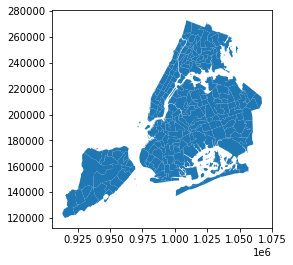

In [1633]:
nta_shape.plot()

In [1634]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# 4. Mapping

## City-Wide

In [1635]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [1636]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [1637]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...           NaN  POINT (997001.000 163787.000)   
37                    NaN  ...  3.067250e+09  POINT (995149.000 165773.000)   
266                   NaN  ...  3.065280e+09  POINT (993187.000 166340.000)   
495                   NaN  ...  3.067170e+09  POINT (995003.000 166819.000)   
662              AVENUE M  ...           NaN  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 39 columns]

<AxesSubplot:>

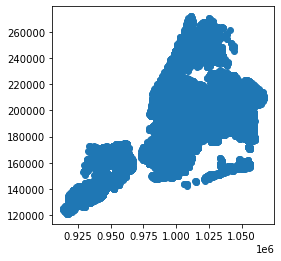

In [1638]:
gdf.plot()

In [1639]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26489 entries, 0 to 11550
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26489 non-null  int64   
 1   created_date                    26489 non-null  object  
 2   closed_date                     26487 non-null  object  
 3   agency                          26489 non-null  object  
 4   agency_name                     26489 non-null  object  
 5   complaint_type                  26489 non-null  object  
 6   descriptor                      26489 non-null  object  
 7   incident_zip                    26489 non-null  float64 
 8   intersection_street_1           9239 non-null   object  
 9   intersection_street_2           9239 non-null   object  
 10  address_type                    26489 non-null  object  
 11  city                            26489 non-null  object  
 12  status    

In [1640]:
gdf.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count  2.648900e+04  26489.000000              2.648900e+04   
mean   3.235187e+07  10970.051040              1.005572e+06   
std    9.130493e+06    536.883961              3.504731e+04   
min    1.563993e+07  10001.000000              9.133570e+05   
25%    2.429458e+07  10312.000000              9.869270e+05   
50%    3.269713e+07  11221.000000              1.007562e+06   
75%    4.019266e+07  11385.000000              1.034055e+06   
max    4.854313e+07  11697.000000              1.067279e+06   

       y_coordinate_state_plane      latitude     longitude           bbl  \
count              26489.000000  26489.000000  26489.000000  1.581600e+04   
mean              186158.396391     40.677543    -73.923057  3.700761e+09   
std                30574.398860      0.083920      0.126309  1.075452e+09   
min               121032.000000     40.498628    -74.254937  0.000000e+00   
25%               161238.000000     40.609097    -73.990342  3.060563e+09   
50%               183608.000000     40.670540    -73.916017  4.069055e+09   
75%               206512.000000     40.733414    -73.820289  4.156503e+09   
max               271876.000000     40.912869    -73.700384  5.080500e+09   

        index_right  
count  26489.000000  
mean     100.182038  
std       58.716575  
min        0.000000  
25%       50.000000  
50%       98.000000  
75%      159.000000  
max      194.000000

In [1641]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [1642]:
ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [1643]:
path = 'data-raw/raw_streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1644]:
streets.shape

(99373, 12)

<AxesSubplot:>

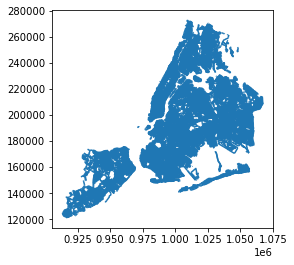

In [1645]:
streets.plot()

In [1646]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99373 entries, 0 to 99372
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [1647]:
streets.geom_type.value_counts()

LineString    99373
dtype: int64

In [1648]:
streets.describe()

shape_leng
count  9.937300e+04
mean   3.430782e+02
std    2.619601e+02
min    1.068681e-08
25%    1.953033e+02
50%    2.648316e+02
75%    4.583296e+02
max    1.509366e+04

# Snap points to lines

In [1649]:
streets.sindex

rtree.index.Index(bounds=[913351.9846191381, 120918.59619133211, 1067379.5294189155, 272688.0944213113], size=99373)

In [1650]:
offset = 80

bbox = gdf.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
0    996921.0  163707.0  997081.0  163867.0
37   995069.0  165693.0  995229.0  165853.0
266  993107.0  166260.0  993267.0  166420.0
495  994923.0  166739.0  995083.0  166899.0
662  996173.0  164488.0  996333.0  164648.0

In [1651]:
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

hits.head()

0                    [39981, 62701, 77130]
37                                 [21518]
266                                [93128]
495                                [90075]
662    [82381, 12302, 53834, 64839, 93420]
dtype: object

In [1652]:
hits.shape

(26489,)

In [1653]:
tmp = pd.DataFrame(
                {
                # index of points table
                "pt_idx": np.repeat(hits.index, hits.apply(len)),
                    
                # ordinal position of line - access via iloc later
                "line_i": np.concatenate(hits.values)
                })

In [1654]:
tmp.head()

pt_idx   line_i
0       0  39981.0
1       0  62701.0
2       0  77130.0
3      37  21518.0
4     266  93128.0

In [1655]:
tmp.shape

(88210, 2)

In [1656]:
streets.shape

(99373, 12)

In [1657]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1658]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx   line_i physicalid   st_label st_name full_stree rw_type  \
0       0  39981.0      38408  OCEAN AVE   OCEAN  OCEAN AVE       1   
1       0  62701.0     116351      AVE N       N      AVE N       1   
2       0  77130.0      45266    E 21 ST      21   E  21 ST       1   
3      37  21518.0      38093    E 15 ST      15   E  15 ST       1   
4     266  93128.0      84855     E 8 ST       8    E  8 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       70         13        13        3  979.978618   
1       Street       34         13        13        3  289.564360   
2       Street       30         13        13        3  880.241028   
3       Street       30         13        13        3  880.087673   
4       Street       28         13        13        3  879.934253   

                                            geometry  
0  LINESTRING (996858.098 163766.777, 996998.445 ...  
1  LINESTRING (996858.098 163766.777, 997014.503 ...  
2  LINESTRING (997019.613 164678.872, 997144.774 ...  
3  LINESTRING (995093.157 166178.478, 995219.607 ...  
4  LINESTRING (993126.698 166782.296, 993252.347 ...

In [1659]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(gdf.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=gdf.crs)

In [1660]:
tmp.head()

pt_idx   line_i physicalid   st_label st_name full_stree rw_type  \
0       0  39981.0      38408  OCEAN AVE   OCEAN  OCEAN AVE       1   
1       0  62701.0     116351      AVE N       N      AVE N       1   
2       0  77130.0      45266    E 21 ST      21   E  21 ST       1   
3      37  21518.0      38093    E 15 ST      15   E  15 ST       1   
4     266  93128.0      84855     E 8 ST       8    E  8 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       70         13        13        3  979.978618   
1       Street       34         13        13        3  289.564360   
2       Street       30         13        13        3  880.241028   
3       Street       30         13        13        3  880.087673   
4       Street       28         13        13        3  879.934253   

                                            geometry  \
0  LINESTRING (996858.098 163766.777, 996998.445 ...   
1  LINESTRING (996858.098 163766.777, 997014.503 ...   
2  LINESTRING (997019.613 164678.872, 997144.774 ...   
3  LINESTRING (995093.157 166178.478, 995219.607 ...   
4  LINESTRING (993126.698 166782.296, 993252.347 ...   

                           point  
0  POINT (997001.000 163787.000)  
1  POINT (997001.000 163787.000)  
2  POINT (997001.000 163787.000)  
3  POINT (995149.000 165773.000)  
4  POINT (993187.000 166340.000)

In [1661]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp.head()

pt_idx   line_i physicalid   st_label st_name full_stree rw_type  \
0       0  39981.0      38408  OCEAN AVE   OCEAN  OCEAN AVE       1   
1       0  62701.0     116351      AVE N       N      AVE N       1   
2       0  77130.0      45266    E 21 ST      21   E  21 ST       1   
3      37  21518.0      38093    E 15 ST      15   E  15 ST       1   
4     266  93128.0      84855     E 8 ST       8    E  8 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       70         13        13        3  979.978618   
1       Street       34         13        13        3  289.564360   
2       Street       30         13        13        3  880.241028   
3       Street       30         13        13        3  880.087673   
4       Street       28         13        13        3  879.934253   

                                            geometry  \
0  LINESTRING (996858.098 163766.777, 996998.445 ...   
1  LINESTRING (996858.098 163766.777, 997014.503 ...   
2  LINESTRING (997019.613 164678.872, 997144.774 ...   
3  LINESTRING (995093.157 166178.478, 995219.607 ...   
4  LINESTRING (993126.698 166782.296, 993252.347 ...   

                           point   snap_dist  
0  POINT (997001.000 163787.000)  144.325300  
1  POINT (997001.000 163787.000)    0.112483  
2  POINT (997001.000 163787.000)  145.238421  
3  POINT (995149.000 165773.000)    2.995146  
4  POINT (993187.000 166340.000)    3.473000

In [1662]:
tmp[['snap_dist']].describe()

snap_dist
count  88210.000000
mean      48.726759
std      109.589224
min        0.000002
25%        0.428120
50%        3.346401
75%       63.551784
max     3109.136264

In [1663]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx   line_i physicalid st_label st_name  full_stree rw_type  \
4895    22445  78884.0      53191    63 ST      63       63 ST       1   
78669    6009  75862.0      12940    99 ST      99       99 ST       1   
78695    7732  75862.0      12940    99 ST      99       99 ST       1   
459     20622  17722.0      45636  E 22 ST      22    E  22 ST       1   
20728   12060  33516.0       1116    8 AVE  EIGHTH  EIGHTH AVE       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
4895        Street       30         13        13        3  778.787201   
78669       Street       56         13        13        4  776.951894   
78695       Street       56         13        13        4  776.951894   
459         Street       30         13        13        3  880.043541   
20728       Street       68         13        13        1  261.957251   

                                                geometry  \
4895   LINESTRING (984162.923 167762.061, 984772.939 ...   
78669  LINESTRING (1022531.087 209487.727, 1022844.15...   
78695  LINESTRING (1022531.087 209487.727, 1022844.15...   
459    LINESTRING (996772.973 168199.186, 996898.570 ...   
20728  LINESTRING (984801.902 211046.822, 984928.407 ...   

                                point  snap_dist  
4895    POINT (984163.000 167762.000)   0.000002  
78669  POINT (1022844.000 208777.000)   0.000026  
78695  POINT (1022844.000 208777.000)   0.000026  
459     POINT (996773.000 168199.000)   0.000030  
20728   POINT (984802.000 211047.000)   0.000045

In [1664]:
tmp[['snap_dist']].describe()

snap_dist
count  72094.000000
mean      16.239087
std       23.937953
min        0.000002
25%        0.357698
50%        2.775206
75%       29.354585
max       79.994171

In [1665]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       62701.0     116351         AVE N         N         AVE N       1   
2       83700.0      50252    MEDFORD RD   MEDFORD    MEDFORD RD       1   
3       65003.0      29374        102 ST       102        102 ST       1   
4       91959.0      81969         6 AVE     SIXTH     SIXTH AVE       1   
5       65520.0      85811  SINCLAIR AVE  SINCLAIR  SINCLAIR AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       34         13        13        3  289.564360   
2            Street       38         13        13        5  152.262314   
3            Street       30         13        13        4  460.174429   
4            Street       30         13        13        4  210.629852   
5            Street       52         13        13        5  276.474790   

                                                 geometry  \
pt_idx                                                      
0       LINESTRING (996858.098 163766.777, 997014.503 ...   
2       LINESTRING (956799.021 158685.832, 956666.437 ...   
3       LINESTRING (1028020.859 190195.595, 1028182.16...   
4       LINESTRING (1035547.870 229595.133, 1035728.72...   
5       LINESTRING (929575.813 136747.390, 929315.915 ...   

                                 point  snap_dist  
pt_idx                                             
0        POINT (997001.000 163787.000)   0.112483  
2        POINT (956757.000 158713.000)   2.994798  
3       POINT (1028044.000 190125.000)   3.073082  
4       POINT (1035553.000 229598.000)   0.168231  
5        POINT (929435.000 136699.000)   2.537471

In [1666]:
closest.index.is_unique

True

In [1667]:
closest.physicalid.is_unique

False

In [1668]:
len(gdf)

26489

In [1669]:
len(closest)

/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


26431

In [1670]:
len(closest)/len(gdf)

0.9978104118690777

In [1671]:
print("We've dropped", str(len(gdf) - len(closest)), '(' + \
      str(round((1 - (len(closest) / len(gdf))) * 100, 2)) + \
      '%) of street flooding complaint points that\nwere more than 80 ft. ' + \
      'from the closest street center line.')

We've dropped 58 (0.22%) of street flooding complaint points that
were more than 80 ft. from the closest street center line.


In [1672]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
0     POINT (997000.984 163787.111)
2     POINT (956755.527 158710.392)
3    POINT (1028046.878 190126.077)
4    POINT (1035552.914 229598.144)
5     POINT (929435.865 136696.615)
dtype: geometry

In [1673]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       62701.0     116351         AVE N         N         AVE N       1   
2       83700.0      50252    MEDFORD RD   MEDFORD    MEDFORD RD       1   
3       65003.0      29374        102 ST       102        102 ST       1   
4       91959.0      81969         6 AVE     SIXTH     SIXTH AVE       1   
5       65520.0      85811  SINCLAIR AVE  SINCLAIR  SINCLAIR AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       34         13        13        3  289.564360   
2            Street       38         13        13        5  152.262314   
3            Street       30         13        13        4  460.174429   
4            Street       30         13        13        4  210.629852   
5            Street       52         13        13        5  276.474790   

                              geometry                           point  \
pt_idx                                                                   
0        POINT (997000.984 163787.111)   POINT (997001.000 163787.000)   
2        POINT (956755.527 158710.392)   POINT (956757.000 158713.000)   
3       POINT (1028046.878 190126.077)  POINT (1028044.000 190125.000)   
4       POINT (1035552.914 229598.144)  POINT (1035553.000 229598.000)   
5        POINT (929435.865 136696.615)   POINT (929435.000 136699.000)   

        snap_dist  
pt_idx             
0        0.112483  
2        2.994798  
3        3.073082  
4        0.168231  
5        2.537471

In [1674]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ... cross_street_1    cross_street_2           bbl  \
0                     NaN  ...   OCEAN AVENUE  EAST   21 STREET           NaN   
37                    NaN  ...       AVENUE K          AVENUE L  3.067250e+09   
266                   NaN  ...       AVENUE J          AVENUE K  3.065280e+09   
495                   NaN  ...       AVENUE J          AVENUE K  3.067170e+09   
662              AVENUE M  ...            NaN               NaN           NaN   

                          geometry index_right ntacode county_fips  ntaname  \
0    POINT (997001.000 163787.000)           8    BK43         047  Midwood   
37   POINT (995149.000 165773.000)           8    BK43         047  Midwood   
266  POINT (993187.000 166340.000)           8    BK43         047  Midwood   
495  POINT (995003.000 166819.000)           8    BK43         047  Midwood   
662  POINT (996253.000 164568.000)           8    BK43         047  Midwood   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 37 columns]

In [1675]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26489 entries, 0 to 11550
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26489 non-null  int64   
 1   created_date                    26489 non-null  object  
 2   closed_date                     26487 non-null  object  
 3   agency                          26489 non-null  object  
 4   agency_name                     26489 non-null  object  
 5   complaint_type                  26489 non-null  object  
 6   descriptor                      26489 non-null  object  
 7   incident_zip                    26489 non-null  float64 
 8   intersection_street_1           9239 non-null   object  
 9   intersection_street_2           9239 non-null   object  
 10  address_type                    26489 non-null  object  
 11  city                            26489 non-null  object  
 12  status    

In [1676]:
gdf.drop(columns=["geometry"], inplace=True)

In [1677]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ...       street_name cross_street_1  \
0                     NaN  ...          AVENUE N   OCEAN AVENUE   
37                    NaN  ...           E 15 ST       AVENUE K   
266                   NaN  ...            E 8 ST       AVENUE J   
495                   NaN  ...  EAST   15 STREET       AVENUE J   
662              AVENUE M  ...               NaN            NaN   

       cross_street_2           bbl index_right ntacode county_fips  ntaname  \
0    EAST   21 STREET           NaN           8    BK43         047  Midwood   
37           AVENUE L  3.067250e+09           8    BK43         047  Midwood   
266          AVENUE K  3.065280e+09           8    BK43         047  Midwood   
495          AVENUE K  3.067170e+09           8    BK43         047  Midwood   
662               NaN           NaN           8    BK43         047  Midwood   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 36 columns]

In [1678]:
snapped.head()

line_i physicalid      st_label   st_name    full_stree rw_type  \
pt_idx                                                                     
0       62701.0     116351         AVE N         N         AVE N       1   
2       83700.0      50252    MEDFORD RD   MEDFORD    MEDFORD RD       1   
3       65003.0      29374        102 ST       102        102 ST       1   
4       91959.0      81969         6 AVE     SIXTH     SIXTH AVE       1   
5       65520.0      85811  SINCLAIR AVE  SINCLAIR  SINCLAIR AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       34         13        13        3  289.564360   
2            Street       38         13        13        5  152.262314   
3            Street       30         13        13        4  460.174429   
4            Street       30         13        13        4  210.629852   
5            Street       52         13        13        5  276.474790   

                              geometry                           point  \
pt_idx                                                                   
0        POINT (997000.984 163787.111)   POINT (997001.000 163787.000)   
2        POINT (956755.527 158710.392)   POINT (956757.000 158713.000)   
3       POINT (1028046.878 190126.077)  POINT (1028044.000 190125.000)   
4       POINT (1035552.914 229598.144)  POINT (1035553.000 229598.000)   
5        POINT (929435.865 136696.615)   POINT (929435.000 136699.000)   

        snap_dist  
pt_idx             
0        0.112483  
2        2.994798  
3        3.073082  
4        0.168231  
5        2.537471

In [1679]:
# Join back to the original points:
updated_points = gdf.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       34         13   
37                    NaN  ...       1       Street       30         13   
266                   NaN  ...       1       Street       28         13   
495                   NaN  ...       1       Street       30         13   
662              AVENUE M  ...       1       Street       42         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        3  289.564360  POINT (997000.984 163787.111)   
37         13        3  880.087673  POINT (995151.964 165773.430)   
266        13        3  879.934253  POINT (993190.437 166340.496)   
495        13        3  878.963440  POINT (995000.274 166818.604)   
662        13        3  147.879998  POINT (996253.027 164567.812)   

                             point snap_dist  
0    POINT (997001.000 163787.000)  0.112483  
37   POINT (995149.000 165773.000)  2.995146  
266  POINT (993187.000 166340.000)  3.473000  
495  POINT (995003.000 166819.000)  2.754567  
662  POINT (996253.000 164568.000)  0.190067  

[5 rows x 51 columns]

In [1680]:
updated_points.geom_type.isna().value_counts()

False    26431
True        58
dtype: int64

In [1681]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       34         13   
37                    NaN  ...       1       Street       30         13   
266                   NaN  ...       1       Street       28         13   
495                   NaN  ...       1       Street       30         13   
662              AVENUE M  ...       1       Street       42         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        3  289.564360  POINT (997000.984 163787.111)   
37         13        3  880.087673  POINT (995151.964 165773.430)   
266        13        3  879.934253  POINT (993190.437 166340.496)   
495        13        3  878.963440  POINT (995000.274 166818.604)   
662        13        3  147.879998  POINT (996253.027 164567.812)   

                             point snap_dist  
0    POINT (997001.000 163787.000)  0.112483  
37   POINT (995149.000 165773.000)  2.995146  
266  POINT (993187.000 166340.000)  3.473000  
495  POINT (995003.000 166819.000)  2.754567  
662  POINT (996253.000 164568.000)  0.190067  

[5 rows x 51 columns]

In [1682]:
updated_points.geom_type.isna().value_counts()

False    26431
dtype: int64

In [1683]:
updated_points.shape

(26431, 51)

In [1684]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
22445    42243506  2019-04-16T08:42:00.000  2019-04-16T11:15:00.000    DEP   
6009     23341412  2012-06-01T09:24:00.000  2012-06-05T09:45:00.000    DEP   
7732     25320481  2013-04-08T11:02:00.000  2013-04-12T09:15:00.000    DEP   
20622    40665956  2018-10-26T13:23:00.000  2018-10-27T09:45:00.000    DEP   
22327    42117184  2019-04-02T10:40:00.000  2019-04-13T11:45:00.000    DEP   

                                  agency_name complaint_type  \
22445  Department of Environmental Protection          Sewer   
6009   Department of Environmental Protection          Sewer   
7732   Department of Environmental Protection          Sewer   
20622  Department of Environmental Protection          Sewer   
22327  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
22445  Street Flooding (SJ)       11219.0             63 STREET   
6009   Street Flooding (SJ)       11368.0             55 AVENUE   
7732   Street Flooding (SJ)       11368.0             55 AVENUE   
20622  Street Flooding (SJ)       11210.0              AVENUE I   
22327  Street Flooding (SJ)       10011.0        WEST 24 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
22445             13 AVENUE  ...       1       Street       30         13   
6009              99 STREET  ...       1       Street       56         13   
7732              99 STREET  ...       1       Street       56         13   
20622        EAST 22 STREET  ...       1       Street       30         13   
22327              8 AVENUE  ...       1       Street       68         13   

      to_lvl_co borocode  shape_leng                        geometry  \
22445        13        3  778.787201   POINT (984163.000 167762.000)   
6009         13        4  776.951894  POINT (1022844.000 208777.000)   
7732         13        4  776.951894  POINT (1022844.000 208777.000)   
20622        13        3  880.043541   POINT (996773.000 168199.000)   
22327        13        1  261.957251   POINT (984802.000 211047.000)   

                                point snap_dist  
22445   POINT (984163.000 167762.000)  0.000002  
6009   POINT (1022844.000 208777.000)  0.000026  
7732   POINT (1022844.000 208777.000)  0.000026  
20622   POINT (996773.000 168199.000)  0.000030  
22327   POINT (984802.000 211047.000)  0.000045  

[5 rows x 51 columns]

In [1685]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
10605    28480099  2014-07-15T15:23:00.000  2014-07-16T03:40:00.000    DEP   
4729     18817559  2010-10-03T15:16:00.000  2010-10-04T10:40:00.000    DEP   
12225    30740271  2015-05-31T20:33:00.000  2015-06-23T08:45:00.000    DEP   
5464     22847904  2012-03-08T13:36:00.000  2012-03-10T09:00:00.000    DEP   
593      46269509  2020-05-22T15:49:00.000  2020-05-23T03:40:00.000    DEP   

                                  agency_name complaint_type  \
10605  Department of Environmental Protection          Sewer   
4729   Department of Environmental Protection          Sewer   
12225  Department of Environmental Protection          Sewer   
5464   Department of Environmental Protection          Sewer   
593    Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
10605  Street Flooding (SJ)       11414.0                   NaN   
4729   Street Flooding (SJ)       10467.0     WHITE PLAINS ROAD   
12225  Street Flooding (SJ)       11414.0                   NaN   
5464   Street Flooding (SJ)       10473.0                   NaN   
593    Street Flooding (SJ)       11414.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
10605                   NaN  ...       1       Street       40         13   
4729        EAST 211 STREET  ...       1       Street       20         13   
12225                   NaN  ...       1       Street       40         13   
5464                    NaN  ...       1       Street       30         13   
593                     NaN  ...       1       Street       24         13   

      to_lvl_co borocode  shape_leng                        geometry  \
10605        13        3  566.479837  POINT (1024165.937 181775.728)   
4729         13        2  171.725774  POINT (1021332.894 259153.397)   
12225        13        3  566.479837  POINT (1024070.126 182327.816)   
5464         13        2  445.892229  POINT (1020826.997 236855.538)   
593          13        3  449.960617  POINT (1022869.338 184432.484)   

                                point  snap_dist  
10605  POINT (1024242.000 181788.000)  77.046677  
4729   POINT (1021264.000 259166.000)  70.037699  
12225  POINT (1024139.000 182340.000)  69.943081  
5464   POINT (1020839.000 236788.000)  68.595955  
593    POINT (1022936.000 184445.000)  67.827009  

[5 rows x 51 columns]

In [1686]:
updated_points[['snap_dist']].describe()

snap_dist
count  26431.000000
mean       2.724204
std        4.451113
min        0.000002
25%        0.238066
50%        2.700088
75%        3.154699
max       77.046677

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

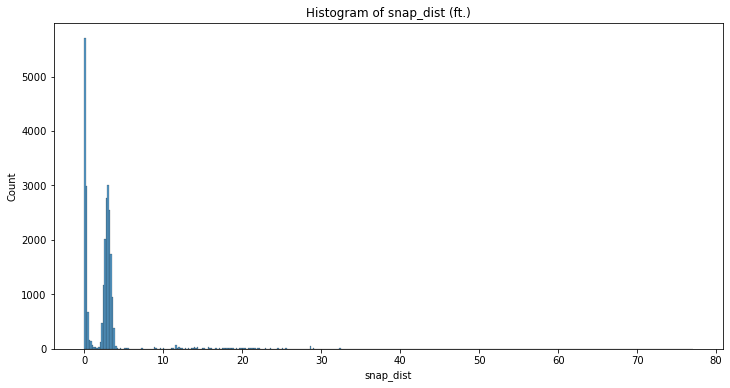

In [1687]:
plt.figure(figsize=(12,6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [1688]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips  ntaname boro_name boro_code   line_i  \
0              8    BK43         047  Midwood  Brooklyn         3  62701.0   
37             8    BK43         047  Midwood  Brooklyn         3  21518.0   
266            8    BK43         047  Midwood  Brooklyn         3  93128.0   
495            8    BK43         047  Midwood  Brooklyn         3  90075.0   
662            8    BK43         047  Midwood  Brooklyn         3  53834.0   

    physicalid st_label st_name full_stree rw_type rw_type_name st_width  \
0       116351    AVE N       N      AVE N       1       Street       34   
37       38093  E 15 ST      15   E  15 ST       1       Street       30   
266      84855   E 8 ST       8    E  8 ST       1       Street       28   
495      38092  E 15 ST      15   E  15 ST       1       Street       30   
662      62814    AVE M       M      AVE M       1       Street       42   

    frm_lvl_co  
0           13  
37          13  
266         13  
495         13  
662         13

In [1689]:
updated_points.physicalid.value_counts()

76941     112
93488      91
44654      88
109590     80
23726      77
         ... 
66778       1
50245       1
74320       1
140         1
11653       1
Name: physicalid, Length: 12657, dtype: int64

In [1690]:
updated_points.physicalid.value_counts().index[0]

'76941'

In [1691]:
top_street_id = updated_points.physicalid.value_counts().index[0]
print(top_street_id)

updated_points.loc[updated_points.physicalid == top_street_id].iloc[:, 30:45].head()

76941


index_right ntacode county_fips                 ntaname      boro_name  \
631           95    SI45         085  New Dorp-Midland Beach  Staten Island   
697           95    SI45         085  New Dorp-Midland Beach  Staten Island   
761           95    SI45         085  New Dorp-Midland Beach  Staten Island   
763           95    SI45         085  New Dorp-Midland Beach  Staten Island   
768           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code   line_i physicalid    st_label  st_name  full_stree rw_type  \
631         5  19429.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
697         5  19429.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
761         5  19429.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
763         5  19429.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
768         5  19429.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
631       Street       22         13  
697       Street       22         13  
761       Street       22         13  
763       Street       22         13  
768       Street       22         13

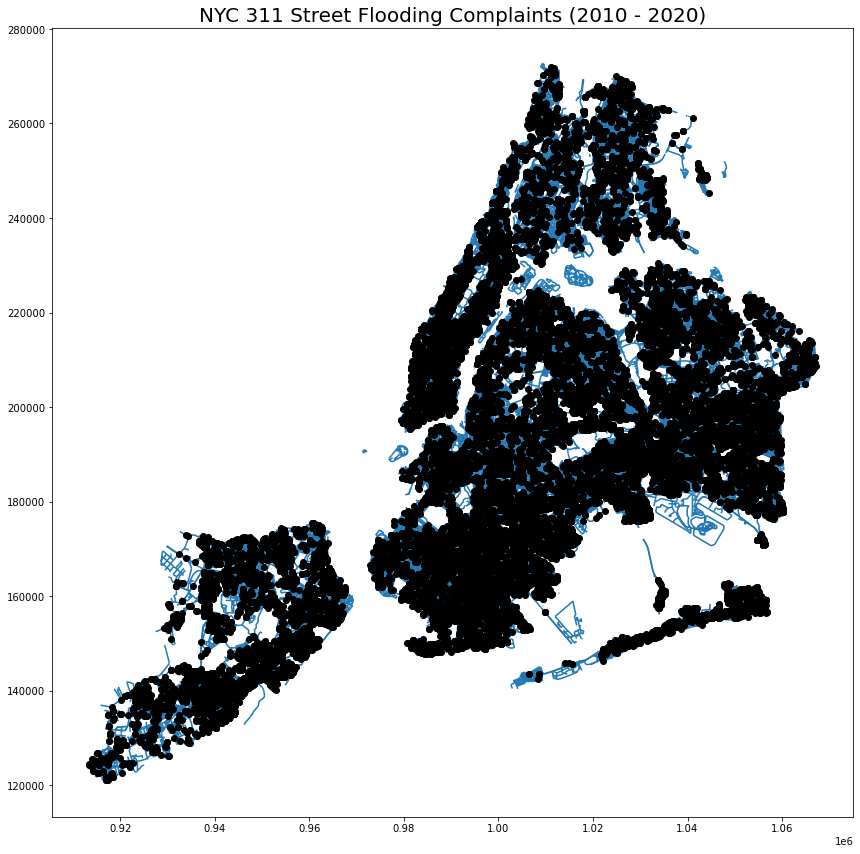

In [1692]:
fig, ax = plt.subplots(figsize=(12, 12))

updated_points.plot(ax=ax, 
                    c='black')

streets.plot(ax=ax, 
             zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints (2010 - 2020)', 
             fontsize=20)

plt.tight_layout()

In [1693]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [1694]:
gdf_count.head()

physicalid  created_date
0     100002             2
1     100019             1
2     100020             1
3      10003             1
4      10004             2

In [1695]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [1696]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [1697]:
streets[['geometry']].head()

geometry
0  LINESTRING (1047146.080 222733.432, 1047385.93...
1  LINESTRING (1009926.638 269075.549, 1010033.71...
2  LINESTRING (989292.818 189689.736, 989648.842 ...
3  LINESTRING (1031371.427 199453.863, 1031412.58...
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1698]:
streets.set_geometry('geometry', inplace=True)

In [1699]:
streets.geom_type.value_counts()

LineString    99373
dtype: int64

In [1700]:
streets['new_geom'] = streets.geometry.buffer(40, cap_style=2)

streets.set_geometry('new_geom', inplace=True)

In [1701]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...  
2  POLYGON ((989665.155 189566.793, 989865.462 18...  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...  
4  POLYGON ((940041.585 144007.708, 940012.801 14...

In [1702]:
streets.geom_type.value_counts()

Polygon         99339
MultiPolygon       34
dtype: int64

In [1703]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99373 entries, 0 to 99372
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
 12  new_geom      99373 non-null  geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 9.9+ MB


In [1704]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [1705]:
gdf_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12657 entries, 0 to 12656
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   physicalid  12657 non-null  object
 1   count       12657 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 197.9+ KB


In [1706]:
streets.shape

(99373, 13)

In [1707]:
# joining our street data to our flood complaints data
streets_with_count = streets.merge(gdf_count, 
                                   left_on='physicalid', 
                                   right_on='physicalid', 
                                   how='left')

In [1708]:
streets_with_count.shape

(99373, 14)

In [1709]:
streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    NaN  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    NaN  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    NaN  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    NaN  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    NaN

In [1710]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99373 entries, 0 to 99372
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
 12  new_geom      99373 non-null  geometry
 13  count         12657 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [1711]:
streets_with_count.isna().sum()

physicalid          0
st_label            0
st_name             0
full_stree          0
rw_type             0
rw_type_name        0
st_width            0
frm_lvl_co          0
to_lvl_co           0
borocode            0
shape_leng          0
geometry            0
new_geom            0
count           86716
dtype: int64

In [1712]:
streets_with_count['count'].fillna(0, inplace=True)

streets_with_count.isna().sum()

physicalid      0
st_label        0
st_name         0
full_stree      0
rw_type         0
rw_type_name    0
st_width        0
frm_lvl_co      0
to_lvl_co       0
borocode        0
shape_leng      0
geometry        0
new_geom        0
count           0
dtype: int64

In [1713]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19429      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66867      93488       157 ST       157       157 ST       1       Street   
56700      44654      MILL RD      MILL      MILL RD       1       Street   
32094     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75676      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
19429       22         13        13        5  372.786118   
66867       35         13        13        4  499.592808   
56700       60         13        13        5  404.812891   
32094       22         13        13        3  554.170960   
75676       30         13        13        4  678.503925   

                                                geometry  \
19429  LINESTRING (958533.655 149022.834, 958315.338 ...   
66867  LINESTRING (1045395.099 182129.719, 1045149.50...   
56700  LINESTRING (952047.152 142027.684, 951841.926 ...   
32094  LINESTRING (1023855.973 183442.797, 1023962.32...   
75676  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  
19429  POLYGON ((958347.761 148697.237, 958282.915 14...  112.0  
66867  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0  
56700  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0  
32094  POLYGON ((1024001.581 182906.603, 1023923.068 ...   80.0  
75676  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0

In [1714]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99373 entries, 0 to 99372
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
 12  new_geom      99373 non-null  geometry
 13  count         99373 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [1715]:
streets_with_count[['count']].describe()

count
count  99373.000000
mean       0.265978
std        1.393371
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      112.000000

In [1716]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [1717]:
streets_with_count[['shape_leng']].describe()

shape_leng
count  99373.000000
mean     846.011377
std      523.636146
min      160.000000
25%      550.605884
50%      689.634868
75%     1076.344542
max    30346.427123

In [1718]:
streets_with_count.describe()

shape_leng         count
count  99373.000000  99373.000000
mean     846.011377      0.265978
std      523.636146      1.393371
min      160.000000      0.000000
25%      550.605884      0.000000
50%      689.634868      0.000000
75%     1076.344542      0.000000
max    30346.427123    112.000000

In [1719]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0

In [1720]:
streets_with_count[['count_per_100ft']].describe()

count_per_100ft
count     99373.000000
mean          0.032008
std           0.176804
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.704680

In [1721]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid            st_label  st_name  full_stree rw_type  \
10777     155472            W 228 ST      228   W  228 ST       1   
19429      76941          GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
97531     173312          LORING AVE   LORING  LORING AVE       1   
59896      17823  FRANCIS LEWIS BLVD    LEWIS  LEWIS BLVD       1   
56700      44654             MILL RD     MILL     MILL RD       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
10777       Street       44         13        13        1  183.615016   
19429       Street       22         13        13        5  905.572235   
97531       Street       30         13        13        3  643.111870   
59896       Street       20         13        13        4  650.977969   
56700       Street       60         13        13        5  969.625782   

                                                geometry  \
10777  LINESTRING (1009588.352 258326.086, 1009580.22...   
19429  LINESTRING (958533.655 149022.834, 958315.338 ...   
97531  LINESTRING (1023724.487 182856.704, 1023962.32...   
59896  LINESTRING (1056604.322 185833.195, 1056520.50...   
56700  LINESTRING (952047.152 142027.684, 951841.926 ...   

                                                new_geom  count  \
10777  POLYGON ((1009551.215 258307.106, 1009609.228 ...   27.0   
19429  POLYGON ((958347.761 148697.237, 958282.915 14...  112.0   
97531  POLYGON ((1023955.332 182938.311, 1023969.316 ...   69.0   
59896  POLYGON ((1056557.484 185614.763, 1056555.807 ...   61.0   
56700  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   

       count_per_100ft  
10777        14.704680  
19429        12.367870  
97531        10.729082  
59896         9.370517  
56700         9.075666

In [1722]:
streets_with_count['count'].sum()

26431.0

In [1723]:
streets_with_count.shape

(99373, 15)

# Joining streets to neighborhoods

In [1724]:
updated_points.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       34         13   
37                    NaN  ...       1       Street       30         13   
266                   NaN  ...       1       Street       28         13   
495                   NaN  ...       1       Street       30         13   
662              AVENUE M  ...       1       Street       42         13   

    to_lvl_co borocode  shape_leng                       geometry  \
0          13        3  289.564360  POINT (997000.984 163787.111)   
37         13        3  880.087673  POINT (995151.964 165773.430)   
266        13        3  879.934253  POINT (993190.437 166340.496)   
495        13        3  878.963440  POINT (995000.274 166818.604)   
662        13        3  147.879998  POINT (996253.027 164567.812)   

                             point snap_dist  
0    POINT (997001.000 163787.000)  0.112483  
37   POINT (995149.000 165773.000)  2.995146  
266  POINT (993187.000 166340.000)  3.473000  
495  POINT (995003.000 166819.000)  2.754567  
662  POINT (996253.000 164568.000)  0.190067  

[5 rows x 51 columns]

In [1725]:
updated_points.shape

(26431, 51)

In [1726]:
updated_points.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'index_right', 'ntacode', 'county_fips',
       'ntaname', 'boro_name', 'boro_code', 'line_i', 'physicalid', 'st_label',
       'st_name', 'full_stree', 'rw_type', 'rw_type_name', 'st_width',
       'frm_lvl_co', 'to_lvl_co', 'borocode', 'shape_leng', 'geometry',
       'point', 'snap_dist'],
      dtype='object')

In [1727]:
streets_with_nta = updated_points[['unique_key', 
                                   'ntacode', 
                                   'county_fips',
                                   'ntaname', 
                                   'boro_name', 
                                   'boro_code', 
                                   'shape_leng', 
                                   'physicalid']]

streets_with_nta.head()

unique_key ntacode county_fips  ntaname boro_name boro_code  shape_leng  \
0      19224496    BK43         047  Midwood  Brooklyn         3  289.564360   
37     19627927    BK43         047  Midwood  Brooklyn         3  880.087673   
266    19792418    BK43         047  Midwood  Brooklyn         3  879.934253   
495    46684378    BK43         047  Midwood  Brooklyn         3  878.963440   
662    48160150    BK43         047  Midwood  Brooklyn         3  147.879998   

    physicalid  
0       116351  
37       38093  
266      84855  
495      38092  
662      62814

In [1728]:
streets_with_nta.physicalid.value_counts()

76941     112
93488      91
44654      88
109590     80
23726      77
         ... 
66778       1
50245       1
74320       1
140         1
11653       1
Name: physicalid, Length: 12657, dtype: int64

In [1729]:
checking_for_duplicates = streets_with_nta.groupby(by=['physicalid', 
                                                       'ntaname', 
                                                       'boro_name'])['shape_leng'].count().reset_index()

checking_for_duplicates.head()

physicalid                  ntaname boro_name  shape_leng
0     100002           Queens Village    Queens           2
1     100019  Lindenwood-Howard Beach    Queens           1
2     100020  Lindenwood-Howard Beach    Queens           1
3      10003            East Elmhurst    Queens           1
4      10004            East Elmhurst    Queens           2

In [1730]:
checking_for_duplicates.rename(columns={"shape_leng": "count_complaints"}, inplace=True)

checking_for_duplicates.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [1731]:
checking_for_duplicates['physicalid'].is_unique

False

In [1732]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=False).head(10)

physicalid                               ntaname      boro_name  \
12319      97041                               Jamaica         Queens   
12318      97041               Briarwood-Jamaica Hills         Queens   
12167       9550                       Jackson Heights         Queens   
12168       9550                          North Corona         Queens   
12044      94540                          Borough Park       Brooklyn   
12045      94540              Kensington-Ocean Parkway       Brooklyn   
11816      93176                              Rosedale         Queens   
11817      93176  Springfield Gardens South-Brookville         Queens   
11180      88110                New Dorp-Midland Beach  Staten Island   
11181      88110                 Oakwood-Oakwood Beach  Staten Island   

       count_complaints  
12319                 2  
12318                 1  
12167                 1  
12168                 1  
12044                 2  
12045                 1  
11816                 1  
11817                 1  
11180                 2  
11181                 1

In [1733]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=[True, False]).head(10)

physicalid                      ntaname  boro_name  count_complaints
199     101556           Marble Hill-Inwood  Manhattan                 1
200     101556  park-cemetery-etc-Manhattan  Manhattan                 1
580      10779               Middle Village     Queens                 1
581      10779                    Ridgewood     Queens                 1
594     109590      Lindenwood-Howard Beach     Queens                55
593     109590                East New York   Brooklyn                25
634       1134                      Clinton  Manhattan                 5
635       1134        Midtown-Midtown South  Manhattan                 3
638       1138                      Clinton  Manhattan                 2
639       1138        Midtown-Midtown South  Manhattan                 1

In [1734]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].shape[0]

146

In [1735]:
duplicates = (len(checking_for_duplicates[checking_for_duplicates.duplicated(subset=
                                                               ['physicalid'], 
                                                               keep=False) == True]) / len(streets_with_count) * 100)


round(duplicates, 2)

0.15

# There are 150 duplicates (.15% of total) of street segments to neighborhoods

In [1736]:
checking_for_duplicates[checking_for_duplicates.physicalid == '109590'].sort_values(by=['physicalid', 
                                                                                        'count_complaints'], 
                                                                                   ascending=[True,
                                                                                              False])

physicalid                  ntaname boro_name  count_complaints
594     109590  Lindenwood-Howard Beach    Queens                55
593     109590            East New York  Brooklyn                25

# Sorting descending by number of complaints on a street in a given NTA. Then removing duplicates.

In [1737]:
unique_streets = checking_for_duplicates.sort_values(by=['physicalid', 
                                                         'count_complaints'], 
                                                     ascending=[True, 
                                                                False]).drop_duplicates('physicalid')

In [1738]:
unique_streets.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [1739]:
unique_streets[unique_streets.physicalid == '109590']

physicalid                  ntaname boro_name  count_complaints
594     109590  Lindenwood-Howard Beach    Queens                55

In [1740]:
unique_streets.physicalid.is_unique

True

In [1741]:
streets_with_count.shape

(99373, 15)

In [1742]:
# joining our nta population data to our nta shapes data
streets_with_count_nta = streets_with_count.merge(unique_streets, 
                                                  left_on='physicalid', 
                                                  right_on='physicalid', 
                                                  how='left')

streets_with_count_nta.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0   
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0   
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0   
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0   
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0   

  ntaname boro_name  count_complaints  
0     NaN       NaN               NaN  
1     NaN       NaN               NaN  
2     NaN       NaN               NaN  
3     NaN       NaN               NaN  
4     NaN       NaN               NaN

In [1743]:
streets_with_count_nta.iloc[:, -3:].describe(include='all')

ntaname boro_name  count_complaints
count         12657     12657      12657.000000
unique          194         5               NaN
top     Great Kills    Queens               NaN
freq            220      4782               NaN
mean            NaN       NaN          2.078376
std             NaN       NaN          3.330915
min             NaN       NaN          1.000000
25%             NaN       NaN          1.000000
50%             NaN       NaN          1.000000
75%             NaN       NaN          2.000000
max             NaN       NaN        112.000000

In [1744]:
streets_with_count_nta.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19429      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66867      93488       157 ST       157       157 ST       1       Street   
56700      44654      MILL RD      MILL      MILL RD       1       Street   
32094     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75676      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
19429       22         13        13        5   905.572235   
66867       35         13        13        4  1159.185617   
56700       60         13        13        5   969.625782   
32094       22         13        13        3  1268.341920   
75676       30         13        13        4  1517.007849   

                                                geometry  \
19429  LINESTRING (958533.655 149022.834, 958315.338 ...   
66867  LINESTRING (1045395.099 182129.719, 1045149.50...   
56700  LINESTRING (952047.152 142027.684, 951841.926 ...   
32094  LINESTRING (1023855.973 183442.797, 1023962.32...   
75676  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  \
19429  POLYGON ((958347.761 148697.237, 958282.915 14...  112.0   
66867  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0   
56700  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   
32094  POLYGON ((1024001.581 182906.603, 1023923.068 ...   80.0   
75676  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0   

       count_per_100ft                               ntaname      boro_name  \
19429        12.367870                New Dorp-Midland Beach  Staten Island   
66867         7.850339  Springfield Gardens South-Brookville         Queens   
56700         9.075666                 Oakwood-Oakwood Beach  Staten Island   
32094         6.307447               Lindenwood-Howard Beach         Queens   
75676         5.075781                          Baisley Park         Queens   

       count_complaints  
19429             112.0  
66867              91.0  
56700              88.0  
32094              55.0  
75676              77.0

In [1745]:
streets_with_count_nta.shape

(99373, 18)

In [1746]:
count_by_nta = streets_with_count_nta[['physicalid',
                                       'full_stree',
                                       'ntaname',
                                       'boro_name',
                                       'count',
                                       'count_per_100ft']]

In [1747]:
count_by_nta.head()

physicalid       full_stree ntaname boro_name  count  count_per_100ft
0       6110           28 AVE     NaN       NaN    0.0              0.0
1      61140    ARLINGTON AVE     NaN       NaN    0.0              0.0
2     145494  SCHERMERHORN ST     NaN       NaN    0.0              0.0
3      12438      QUEENS BLVD     NaN       NaN    0.0              0.0
4      15432    ARTHUR KIL RD     NaN       NaN    0.0              0.0

In [1748]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19429      76941   GRIMSBY ST                New Dorp-Midland Beach   
66867      93488       157 ST  Springfield Gardens South-Brookville   
56700      44654      MILL RD                 Oakwood-Oakwood Beach   
32094     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75676      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  
19429  Staten Island  112.0        12.367870  
66867         Queens   91.0         7.850339  
56700  Staten Island   88.0         9.075666  
32094         Queens   80.0         6.307447  
75676         Queens   77.0         5.075781

In [1749]:
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

physicalid  full_stree                 ntaname      boro_name  count  \
10777     155472   W  228 ST      Marble Hill-Inwood      Manhattan   27.0   
19429      76941  GRIMSBY ST  New Dorp-Midland Beach  Staten Island  112.0   
97531     173312  LORING AVE           East New York       Brooklyn   69.0   
59896      17823  LEWIS BLVD               Laurelton         Queens   61.0   
56700      44654     MILL RD   Oakwood-Oakwood Beach  Staten Island   88.0   

       count_per_100ft  
10777        14.704680  
19429        12.367870  
97531        10.729082  
59896         9.370517  
56700         9.075666

In [1750]:
count_by_nta.physicalid.is_unique

True

In [1751]:
count_by_nta.describe()

count  count_per_100ft
count  99373.000000     99373.000000
mean       0.265978         0.032008
std        1.393371         0.176804
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      112.000000        14.704680

# sanity check

In [1752]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().sort_values(
                                by='count', 
                                ascending=False).head()

physicalid   full_stree  count  count_per_100ft
78517      76941   GRIMSBY ST  112.0        12.367870
93407      93488       157 ST   91.0         7.850339
47931      44654      MILL RD   88.0         9.075666
5590      109590  SAPPHIRE ST   80.0         6.307447
27605      23726       141 ST   77.0         5.075781

In [1753]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().describe()

count  count_per_100ft
count  99373.000000     99373.000000
mean       0.265978         0.032008
std        1.393371         0.176804
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      112.000000        14.704680

# adding nta information

In [1754]:
count_by_nta['with_nta_name'] = count_by_nta['full_stree'] + \
                                ' (id: ' + \
                                count_by_nta['physicalid'] + \
                                "), " + \
                                count_by_nta['ntaname'] + \
                                ", " + \
                                count_by_nta['boro_name']

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [1755]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19429      76941   GRIMSBY ST                New Dorp-Midland Beach   
66867      93488       157 ST  Springfield Gardens South-Brookville   
56700      44654      MILL RD                 Oakwood-Oakwood Beach   
32094     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75676      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  \
19429  Staten Island  112.0        12.367870   
66867         Queens   91.0         7.850339   
56700  Staten Island   88.0         9.075666   
32094         Queens   80.0         6.307447   
75676         Queens   77.0         5.075781   

                                           with_nta_name  
19429  GRIMSBY ST (id: 76941), New Dorp-Midland Beach...  
66867  157 ST (id: 93488), Springfield Gardens South-...  
56700  MILL RD (id: 44654), Oakwood-Oakwood Beach, St...  
32094  SAPPHIRE ST (id: 109590), Lindenwood-Howard Be...  
75676           141 ST (id: 23726), Baisley Park, Queens

In [1756]:
count_by_nta['physicalid'].is_unique

True

In [1757]:
count_by_nta['with_nta_name'].is_unique

False

In [1758]:
count_by_nta.head()

physicalid       full_stree ntaname boro_name  count  count_per_100ft  \
0       6110           28 AVE     NaN       NaN    0.0              0.0   
1      61140    ARLINGTON AVE     NaN       NaN    0.0              0.0   
2     145494  SCHERMERHORN ST     NaN       NaN    0.0              0.0   
3      12438      QUEENS BLVD     NaN       NaN    0.0              0.0   
4      15432    ARTHUR KIL RD     NaN       NaN    0.0              0.0   

  with_nta_name  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

In [1759]:
count_by_nta['with_nta_name'].value_counts()

BRUCKNER BLVD (id: 41398), Hunts Point, Bronx                                          1
MITCHEL LN (id: 99108), Westerleigh, Staten Island                                     1
W  49 ST (id: 72633), Midtown-Midtown South, Manhattan                                 1
FIGUREA AVE (id: 100689), Annadale-Huguenot-Prince's Bay-Eltingville, Staten Island    1
FILLMORE AVE (id: 48783), Georgetown-Marine Park-Bergen Beach-Mill Basin, Brooklyn     1
                                                                                      ..
129 AVE (id: 76753), St. Albans, Queens                                                1
FIFTH AVE (id: 53450), Bay Ridge, Brooklyn                                             1
PARK AVE (id: 2465), East Harlem North, Manhattan                                      1
UTICA AVE (id: 68651), Rugby-Remsen Village, Brooklyn                                  1
37 AVE (id: 9461), Jackson Heights, Queens                                             1
Name: with_nta_name, 

In [1760]:
count_by_nta['with_nta_name'].value_counts(dropna=False)

NaN                                                                                    86716
UNION HALL ST (id: 32235), South Jamaica, Queens                                           1
B 29 ST (id: 81103), Far Rockaway-Bayswater, Queens                                        1
W  49 ST (id: 72633), Midtown-Midtown South, Manhattan                                     1
FIGUREA AVE (id: 100689), Annadale-Huguenot-Prince's Bay-Eltingville, Staten Island        1
                                                                                       ...  
128 ST (id: 17136), South Ozone Park, Queens                                               1
129 AVE (id: 76753), St. Albans, Queens                                                    1
FIFTH AVE (id: 53450), Bay Ridge, Brooklyn                                                 1
PARK AVE (id: 2465), East Harlem North, Manhattan                                          1
37 AVE (id: 9461), Jackson Heights, Queens                            

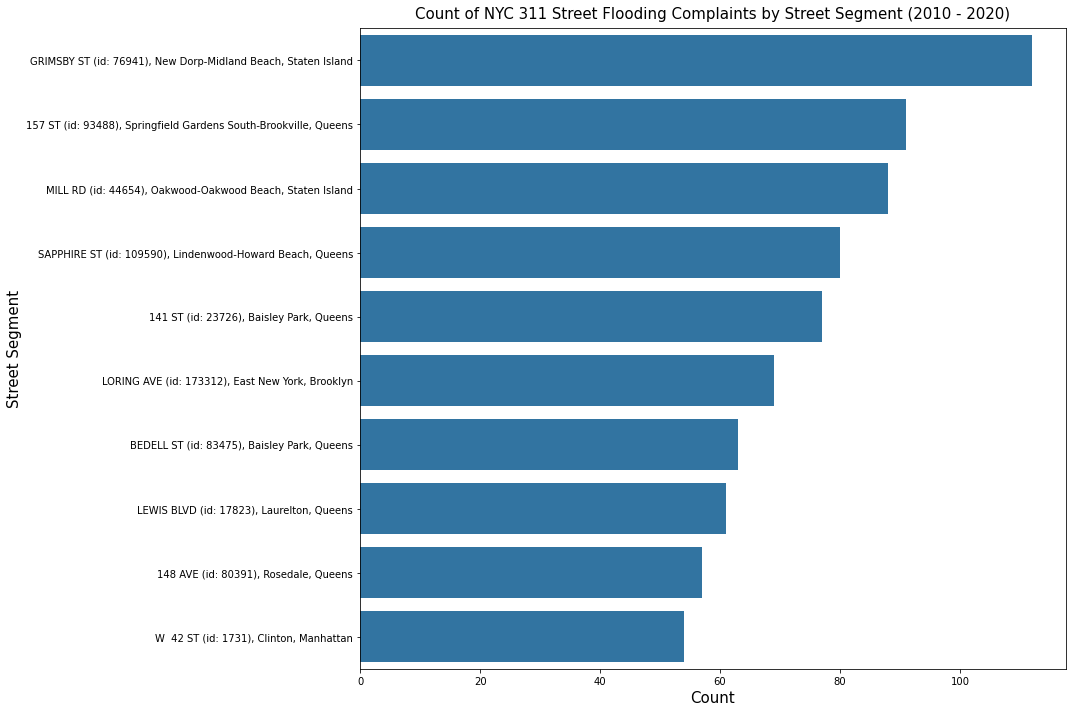

In [1761]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

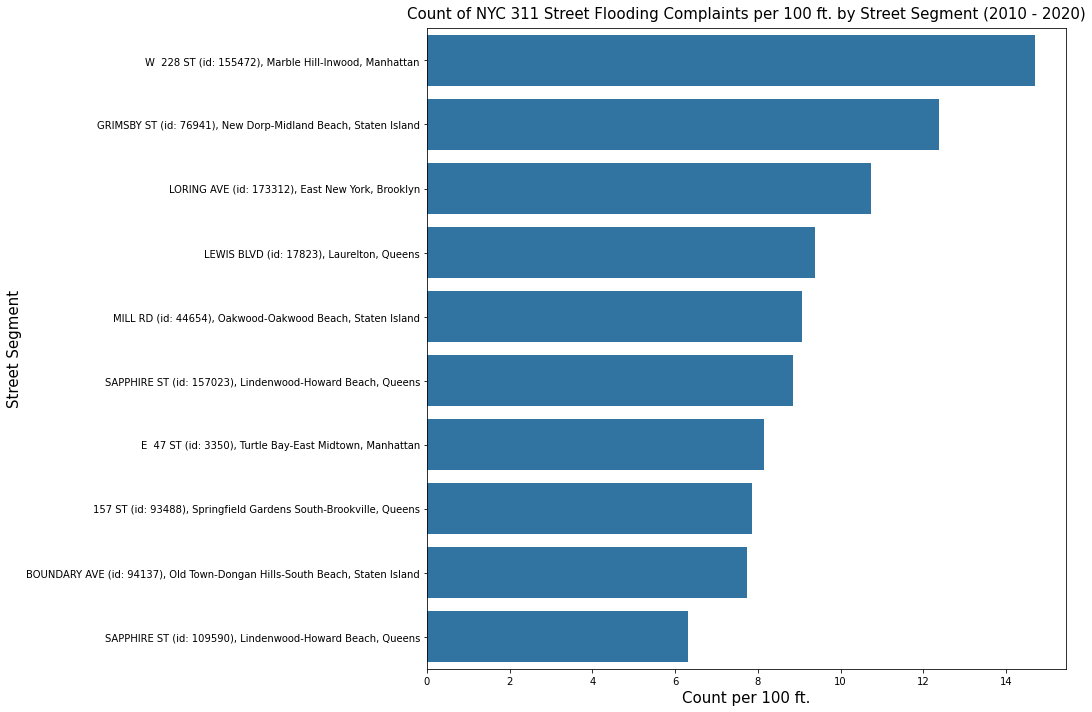

In [1762]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per 100 ft.', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

plt.savefig('figures/count_per_length.png')

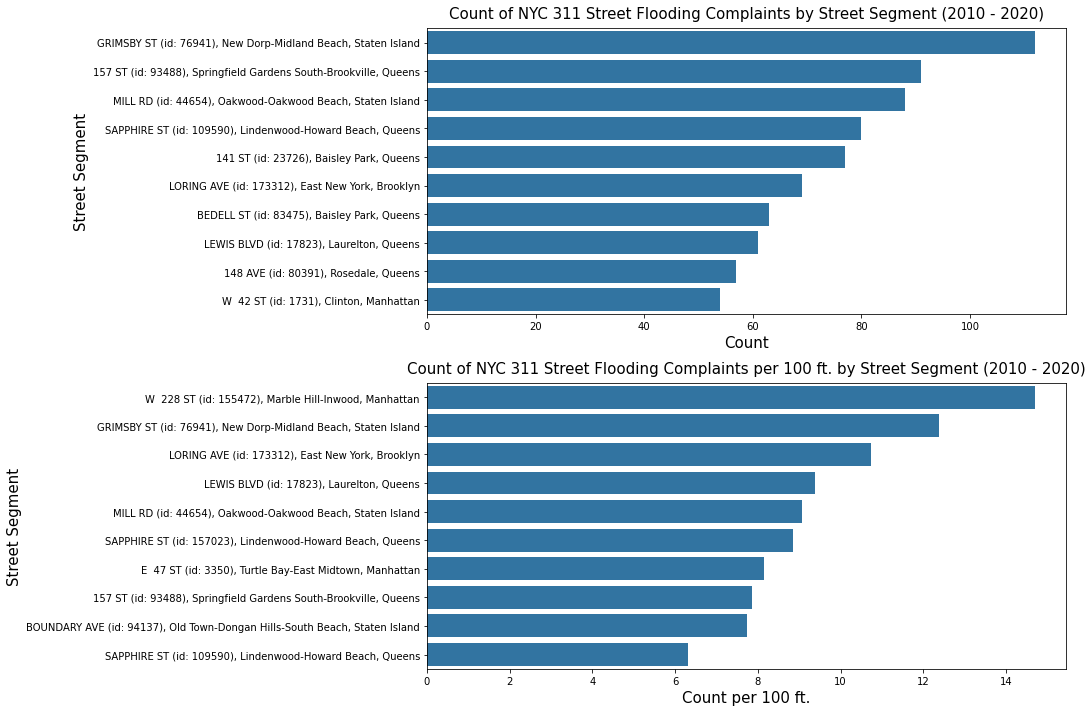

In [1763]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()
plt.savefig('figures/pres-15.png')

In [1764]:
count_by_nta.to_csv('data-output/streets-with-count.csv', index=False)

## Case Studies

## 1) Hammels, Arverne, and Edgemere, Queens and 2) New Dorp - Midland Beach, Staten Island

In [1765]:
top_nta = gpd.GeoDataFrame(flooding_311, 
                           geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                       flooding_311.y_coordinate_state_plane))

top_nta.head()

unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   
5    19501131  2010-12-30T12:31:00.000  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11210.0                   NaN   
2  Street Flooding (SJ)       10304.0                   NaN   
3  Street Flooding (SJ)       11416.0                   NaN   
4  Street Flooding (SJ)       11357.0                 6 AVE   
5  Street Flooding (SJ)       10312.0                   NaN   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...       BROOKLYN  40.616225 -73.954072   
2                   NaN  ...  STATEN ISLAND  40.602264 -74.099007   
3                   NaN  ...         QUEENS  40.688418 -73.842086   
4       CLINTONVILLE ST  ...         QUEENS  40.796721 -73.814709   
5                   NaN  ...  STATEN ISLAND  40.541713 -74.197220   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN   
2    MEDFORD RD       KEUNE CT         FOREST RD  5.008420e+09   
3        102 ST         95 AVE            97 AVE  4.093790e+09   
4           NaN          6 AVE   CLINTONVILLE ST           NaN   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL  5.068490e+09   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 31 columns]

In [1766]:
top_nta.set_crs(epsg=2263, inplace=True)
top_nta.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

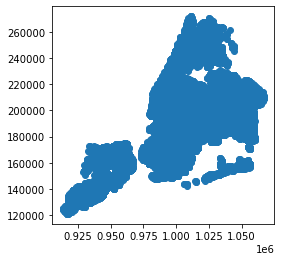

In [1767]:
top_nta.plot()

In [1768]:
gdf.shape

(26489, 36)

In [1769]:
top_nta = gpd.sjoin(top_nta, 
                    nta_shape, 
                    how="inner", 
                    op='within')

In [1770]:
top_nta.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...           NaN  POINT (997001.000 163787.000)   
37                    NaN  ...  3.067250e+09  POINT (995149.000 165773.000)   
266                   NaN  ...  3.065280e+09  POINT (993187.000 166340.000)   
495                   NaN  ...  3.067170e+09  POINT (995003.000 166819.000)   
662              AVENUE M  ...           NaN  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 39 columns]

# Neighborhoods with the most street flooding complaints

In [1771]:
top_nta.groupby(by='ntaname')['unique_key'].count().reset_index().sort_values('unique_key', ascending=False).head(2)

ntaname  unique_key
116    New Dorp-Midland Beach         755
80   Hammels-Arverne-Edgemere         695

## Hammels, Arverne, and Edgemere, Queens

In [1772]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [1773]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   
5    19501131  2010-12-30T12:31:00.000  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11210.0                   NaN   
2  Street Flooding (SJ)       10304.0                   NaN   
3  Street Flooding (SJ)       11416.0                   NaN   
4  Street Flooding (SJ)       11357.0                 6 AVE   
5  Street Flooding (SJ)       10312.0                   NaN   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...       BROOKLYN  40.616225 -73.954072   
2                   NaN  ...  STATEN ISLAND  40.602264 -74.099007   
3                   NaN  ...         QUEENS  40.688418 -73.842086   
4       CLINTONVILLE ST  ...         QUEENS  40.796721 -73.814709   
5                   NaN  ...  STATEN ISLAND  40.541713 -74.197220   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN   
2    MEDFORD RD       KEUNE CT         FOREST RD  5.008420e+09   
3        102 ST         95 AVE            97 AVE  4.093790e+09   
4           NaN          6 AVE   CLINTONVILLE ST           NaN   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL  5.068490e+09   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 31 columns]

In [1774]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

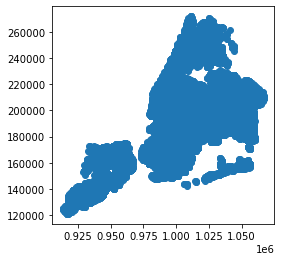

In [1775]:
gdf.plot()

In [1776]:
gdf.shape

(26491, 31)

In [1777]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [1778]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...           NaN  POINT (997001.000 163787.000)   
37                    NaN  ...  3.067250e+09  POINT (995149.000 165773.000)   
266                   NaN  ...  3.065280e+09  POINT (993187.000 166340.000)   
495                   NaN  ...  3.067170e+09  POINT (995003.000 166819.000)   
662              AVENUE M  ...           NaN  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 39 columns]

In [1779]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [1780]:
ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [1781]:
path = 'data-raw/raw_streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1782]:
streets.shape

(99373, 12)

<AxesSubplot:>

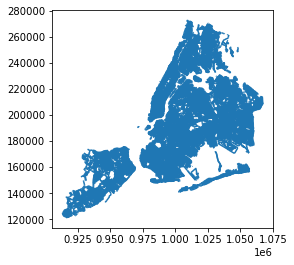

In [1783]:
streets.plot()

In [1784]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99373 entries, 0 to 99372
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [1785]:
streets.describe()

shape_leng
count  9.937300e+04
mean   3.430782e+02
std    2.619601e+02
min    1.068681e-08
25%    1.953033e+02
50%    2.648316e+02
75%    4.583296e+02
max    1.509366e+04

In [1786]:
streets.geom_type.value_counts()

LineString    99373
dtype: int64

In [1787]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1788]:
Hammels_Arverne_Edgemere = nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere']

In [1789]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, Hammels_Arverne_Edgemere)

<AxesSubplot:>

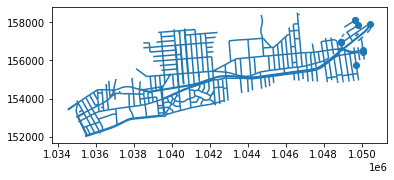

In [1790]:
streets_clipped.plot()

In [1791]:
streets_clipped.geom_type.value_counts()

LineString            843
Point                   9
MultiLineString         2
GeometryCollection      1
dtype: int64

In [1792]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [1793]:
# clipping the school points that only fall within the nta shapes
Hammels_Arverne_Edgemere = gpd.clip(gdf, 
                                    Hammels_Arverne_Edgemere)

<AxesSubplot:>

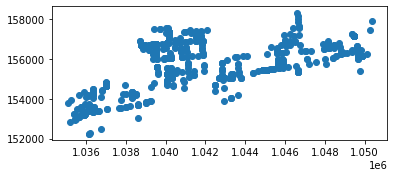

In [1794]:
Hammels_Arverne_Edgemere.plot()

In [1795]:
Hammels_Arverne_Edgemere.geom_type.value_counts()

Point    695
dtype: int64

# Snap points to streets

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [1796]:
streets_clipped.sindex

rtree.index.Index(bounds=[1034529.2977429869, 151996.05628808722, 1050540.0391240292, 158513.33282463337], size=843)

In [1797]:
offset = 80

bbox = Hammels_Arverne_Edgemere.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
269  1049682.0  155330.0  1049842.0  155490.0
660  1040684.0  156458.0  1040844.0  156618.0
762  1038680.0  156603.0  1038840.0  156763.0
771  1042384.0  154601.0  1042544.0  154761.0
799  1041177.0  157211.0  1041337.0  157371.0

In [1798]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

269    [643, 680, 55]
660         [520, 28]
762        [591, 687]
771             [642]
799         [271, 74]
dtype: object

In [1799]:
hits.shape

(695,)

In [1800]:
tmp = pd.DataFrame(
    {
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [1801]:
tmp.head()

pt_idx  line_i
0     269   643.0
1     269   680.0
2     269    55.0
3     660   520.0
4     660    28.0

In [1802]:
tmp.shape

(2130, 2)

In [1803]:
streets_clipped.shape

(843, 12)

In [1804]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
254       14294            BCH 74 ST            B 74             B 74 ST   
349       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
510      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1020      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
254        1       Street       30         13        13        4  623.015421   
349        1       Street       35         13        13        4  234.071915   
510        1       Street       31         13        13        4  255.930554   
1020       1       Street       24         13        13        4  186.284190   

                                               geometry  
41    LINESTRING (1041022.181 156864.681, 1040981.69...  
254   LINESTRING (1039173.301 154571.323, 1039121.22...  
349   LINESTRING (1046371.747 155628.532, 1046139.47...  
510   LINESTRING (1041944.905 154892.163, 1041702.46...  
1020  LINESTRING (1036423.096 153354.452, 1036408.71...

In [1805]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), 
               on="line_i")

tmp.head()

pt_idx  line_i physicalid   st_label st_name full_stree rw_type  \
0     269   643.0     103761    SURF RD    SURF    SURF RD       1   
1     269   680.0      80865  BCH 32 ST    B 32    B 32 ST       1   
2     269    55.0      80866  BCH 32 ST    B 32    B 32 ST       1   
3     660   520.0      14606  BCH 67 ST    B 67    B 67 ST       1   
4     660    28.0      14602  BCH 67 ST    B 67    B 67 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       16         13        13        4  200.496084   
1       Street       38         13        13        4  270.700245   
2       Street       32         13        13        4  171.796252   
3       Street       20         13        13        4  748.829794   
4       Street       20         13        13        4  748.245699   

                                            geometry  
0  LINESTRING (1049753.305 155485.235, 1049753.30...  
1  LINESTRING (1049753.305 155485.235, 1049711.65...  
2  LINESTRING (1049779.739 155315.485, 1049753.30...  
3  LINESTRING (1040785.561 156094.302, 1040730.63...  
4  LINESTRING (1040815.925 156097.308, 1040758.19...

In [1806]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(Hammels_Arverne_Edgemere.geometry.rename("point"), 
               on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, 
                       geometry="geometry", 
                       crs=Hammels_Arverne_Edgemere.crs)

In [1807]:
tmp.head()

pt_idx  line_i physicalid   st_label st_name full_stree rw_type  \
0     269   643.0     103761    SURF RD    SURF    SURF RD       1   
1     269   680.0      80865  BCH 32 ST    B 32    B 32 ST       1   
2     269    55.0      80866  BCH 32 ST    B 32    B 32 ST       1   
3     660   520.0      14606  BCH 67 ST    B 67    B 67 ST       1   
4     660    28.0      14602  BCH 67 ST    B 67    B 67 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       16         13        13        4  200.496084   
1       Street       38         13        13        4  270.700245   
2       Street       32         13        13        4  171.796252   
3       Street       20         13        13        4  748.829794   
4       Street       20         13        13        4  748.245699   

                                            geometry  \
0  LINESTRING (1049753.305 155485.235, 1049753.30...   
1  LINESTRING (1049753.305 155485.235, 1049711.65...   
2  LINESTRING (1049779.739 155315.485, 1049753.30...   
3  LINESTRING (1040785.561 156094.302, 1040730.63...   
4  LINESTRING (1040815.925 156097.308, 1040758.19...   

                            point  
0  POINT (1049762.000 155410.000)  
1  POINT (1049762.000 155410.000)  
2  POINT (1049762.000 155410.000)  
3  POINT (1040764.000 156538.000)  
4  POINT (1040764.000 156538.000)

In [1808]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2130.000000
mean     32.794978
std      49.801287
min       0.004010
25%       0.488686
50%       7.131021
75%      57.519896
max     377.414126

In [1809]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid        st_label  st_name      full_stree  \
1285   17710   312.0      14365  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   
500     8315   413.0      80917       BCH 48 ST       48       BCH 48 ST   
1058   13632   413.0      80917       BCH 48 ST       48       BCH 48 ST   
807    12513   413.0      80917       BCH 48 ST       48       BCH 48 ST   
903    13478   334.0      14195  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1285       1       Street       50         13        13        4  261.689492   
500        1       Street       30         13        13        4  570.432126   
1058       1       Street       30         13        13        4  570.432126   
807        1       Street       30         13        13        4  570.432126   
903        1       Street       52         13        13        4  308.269676   

                                               geometry  \
1285  LINESTRING (1043336.353 156058.630, 1043104.72...   
500   LINESTRING (1045615.013 156289.929, 1045564.12...   
1058  LINESTRING (1045615.013 156289.929, 1045564.12...   
807   LINESTRING (1045615.013 156289.929, 1045564.12...   
903   LINESTRING (1038297.735 154234.529, 1037989.55...   

                               point  snap_dist  
1285  POINT (1043105.000 155937.000)   0.004010  
500   POINT (1045615.000 156290.000)   0.006761  
1058  POINT (1045615.000 156290.000)   0.006761  
807   POINT (1045615.000 156290.000)   0.006761  
903   POINT (1037990.000 154242.000)   0.011789

In [1810]:
tmp[['snap_dist']].describe()

snap_dist
count  1839.000000
mean     16.903357
std      23.853227
min       0.004010
25%       0.445622
50%       3.180381
75%      21.606412
max      78.864107

In [1811]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                              
269       55.0      80866   BCH 32 ST    B 32     B 32 ST       1   
660      520.0      14606   BCH 67 ST    B 67     B 67 ST       1   
762      591.0      14105  ALMEDA AVE  ALMEDA  ALMEDA AVE       1   
771      642.0      14297   BCH 61 ST      61   BCH 61 ST       1   
799      271.0      80858   BCH 65 ST    B 65     B 65 ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
269          Street       32         13        13        4  171.796252   
660          Street       20         13        13        4  748.829794   
762          Street       30         13        13        4  335.367645   
771          Street       30         13        13        4  395.447315   
799          Street       30         13        13        4  495.996377   

                                                 geometry  \
pt_idx                                                      
269     LINESTRING (1049779.739 155315.485, 1049753.30...   
660     LINESTRING (1040785.561 156094.302, 1040730.63...   
762     LINESTRING (1038844.394 156685.481, 1038509.66...   
771     LINESTRING (1042468.048 154593.167, 1042437.32...   
799     LINESTRING (1041287.834 156886.358, 1041246.96...   

                                 point  snap_dist  
pt_idx                                             
269     POINT (1049762.000 155410.000)   2.985026  
660     POINT (1040764.000 156538.000)  11.040937  
762     POINT (1038760.000 156683.000)   2.716166  
771     POINT (1042464.000 154681.000)   2.788963  
799     POINT (1041257.000 157291.000)   2.610411

In [1812]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
269    POINT (1049764.949 155410.459)
660    POINT (1040752.989 156537.190)
762    POINT (1038760.167 156680.289)
771    POINT (1042461.219 154680.783)
799    POINT (1041254.398 157290.785)
dtype: geometry

In [1813]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, 
                           geometry=new_pts)

snapped.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                              
269       55.0      80866   BCH 32 ST    B 32     B 32 ST       1   
660      520.0      14606   BCH 67 ST    B 67     B 67 ST       1   
762      591.0      14105  ALMEDA AVE  ALMEDA  ALMEDA AVE       1   
771      642.0      14297   BCH 61 ST      61   BCH 61 ST       1   
799      271.0      80858   BCH 65 ST    B 65     B 65 ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
269          Street       32         13        13        4  171.796252   
660          Street       20         13        13        4  748.829794   
762          Street       30         13        13        4  335.367645   
771          Street       30         13        13        4  395.447315   
799          Street       30         13        13        4  495.996377   

                              geometry                           point  \
pt_idx                                                                   
269     POINT (1049764.949 155410.459)  POINT (1049762.000 155410.000)   
660     POINT (1040752.989 156537.190)  POINT (1040764.000 156538.000)   
762     POINT (1038760.167 156680.289)  POINT (1038760.000 156683.000)   
771     POINT (1042461.219 154680.783)  POINT (1042464.000 154681.000)   
799     POINT (1041254.398 157290.785)  POINT (1041257.000 157291.000)   

        snap_dist  
pt_idx             
269      2.985026  
660     11.040937  
762      2.716166  
771      2.788963  
799      2.610411

In [1814]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
269    19802148  2011-02-09T15:39:00.000  2011-02-14T13:29:00.000    DEP   
660    48012064  2020-10-29T18:50:00.000  2020-10-29T21:10:00.000    DEP   
762    46061896  2020-04-24T10:55:00.000  2020-04-25T17:25:00.000    DEP   
771    46095009  2020-04-30T10:30:00.000  2020-05-05T10:10:00.000    DEP   
799    46210453  2020-05-15T16:55:00.000  2020-05-16T09:10:00.000    DEP   

                                agency_name complaint_type  \
269  Department of Environmental Protection          Sewer   
660  Department of Environmental Protection          Sewer   
762  Department of Environmental Protection          Sewer   
771  Department of Environmental Protection          Sewer   
799  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
269  Street Flooding (SJ)       11691.0                   NaN   
660  Street Flooding (SJ)       11692.0                   NaN   
762  Street Flooding (SJ)       11692.0                   NaN   
771  Street Flooding (SJ)       11692.0                   NaN   
799  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ... cross_street_1       cross_street_2  \
269                   NaN  ...  SPRAYVIEW AVE              SURF RD   
660                   NaN  ...    THURSBY AVE           ALMEDA AVE   
762                   NaN  ...   BARBADOES DR             DEAD END   
771                   NaN  ...     LARKIN AVE  ROCKAWAY BEACH BLVD   
799                   NaN  ...     ALMEDA AVE         DE COSTA AVE   

              bbl                        geometry index_right ntacode  \
269  4.158590e+09  POINT (1049762.000 155410.000)         131    QN12   
660  4.160340e+09  POINT (1040764.000 156538.000)         131    QN12   
762  4.160620e+09  POINT (1038760.000 156683.000)         131    QN12   
771  4.159030e+09  POINT (1042464.000 154681.000)         131    QN12   
799  4.160240e+09  POINT (1041257.000 157291.000)         131    QN12   

    county_fips                   ntaname  boro_name boro_code  
269         081  Hammels-Arverne-Edgemere     Queens         4  
660         081  Hammels-Arverne-Edgemere     Queens         4  
762         081  Hammels-Arverne-Edgemere     Queens         4  
771         081  Hammels-Arverne-Edgemere     Queens         4  
799         081  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 37 columns]

In [1815]:
Hammels_Arverne_Edgemere.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 695 entries, 269 to 27388
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      695 non-null    int64   
 1   created_date                    695 non-null    object  
 2   closed_date                     695 non-null    object  
 3   agency                          695 non-null    object  
 4   agency_name                     695 non-null    object  
 5   complaint_type                  695 non-null    object  
 6   descriptor                      695 non-null    object  
 7   incident_zip                    695 non-null    float64 
 8   intersection_street_1           207 non-null    object  
 9   intersection_street_2           207 non-null    object  
 10  address_type                    695 non-null    object  
 11  city                            695 non-null    object  
 12  status    

In [1816]:
Hammels_Arverne_Edgemere.drop(columns=["geometry"], inplace=True)

In [1817]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
269    19802148  2011-02-09T15:39:00.000  2011-02-14T13:29:00.000    DEP   
660    48012064  2020-10-29T18:50:00.000  2020-10-29T21:10:00.000    DEP   
762    46061896  2020-04-24T10:55:00.000  2020-04-25T17:25:00.000    DEP   
771    46095009  2020-04-30T10:30:00.000  2020-05-05T10:10:00.000    DEP   
799    46210453  2020-05-15T16:55:00.000  2020-05-16T09:10:00.000    DEP   

                                agency_name complaint_type  \
269  Department of Environmental Protection          Sewer   
660  Department of Environmental Protection          Sewer   
762  Department of Environmental Protection          Sewer   
771  Department of Environmental Protection          Sewer   
799  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
269  Street Flooding (SJ)       11691.0                   NaN   
660  Street Flooding (SJ)       11692.0                   NaN   
762  Street Flooding (SJ)       11692.0                   NaN   
771  Street Flooding (SJ)       11692.0                   NaN   
799  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ...        street_name cross_street_1  \
269                   NaN  ...        BEACH 32 ST  SPRAYVIEW AVE   
660                   NaN  ...  BEACH   67 STREET    THURSBY AVE   
762                   NaN  ...      ALMEDA AVENUE   BARBADOES DR   
771                   NaN  ...  BEACH   61 STREET     LARKIN AVE   
799                   NaN  ...  BEACH   65 STREET     ALMEDA AVE   

          cross_street_2           bbl index_right ntacode county_fips  \
269              SURF RD  4.158590e+09         131    QN12         081   
660           ALMEDA AVE  4.160340e+09         131    QN12         081   
762             DEAD END  4.160620e+09         131    QN12         081   
771  ROCKAWAY BEACH BLVD  4.159030e+09         131    QN12         081   
799         DE COSTA AVE  4.160240e+09         131    QN12         081   

                      ntaname  boro_name boro_code  
269  Hammels-Arverne-Edgemere     Queens         4  
660  Hammels-Arverne-Edgemere     Queens         4  
762  Hammels-Arverne-Edgemere     Queens         4  
771  Hammels-Arverne-Edgemere     Queens         4  
799  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 36 columns]

In [1818]:
snapped.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                              
269       55.0      80866   BCH 32 ST    B 32     B 32 ST       1   
660      520.0      14606   BCH 67 ST    B 67     B 67 ST       1   
762      591.0      14105  ALMEDA AVE  ALMEDA  ALMEDA AVE       1   
771      642.0      14297   BCH 61 ST      61   BCH 61 ST       1   
799      271.0      80858   BCH 65 ST    B 65     B 65 ST       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
269          Street       32         13        13        4  171.796252   
660          Street       20         13        13        4  748.829794   
762          Street       30         13        13        4  335.367645   
771          Street       30         13        13        4  395.447315   
799          Street       30         13        13        4  495.996377   

                              geometry                           point  \
pt_idx                                                                   
269     POINT (1049764.949 155410.459)  POINT (1049762.000 155410.000)   
660     POINT (1040752.989 156537.190)  POINT (1040764.000 156538.000)   
762     POINT (1038760.167 156680.289)  POINT (1038760.000 156683.000)   
771     POINT (1042461.219 154680.783)  POINT (1042464.000 154681.000)   
799     POINT (1041254.398 157290.785)  POINT (1041257.000 157291.000)   

        snap_dist  
pt_idx             
269      2.985026  
660     11.040937  
762      2.716166  
771      2.788963  
799      2.610411

In [1819]:
# Join back to the original points:
updated_points = Hammels_Arverne_Edgemere.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
269    19802148  2011-02-09T15:39:00.000  2011-02-14T13:29:00.000    DEP   
660    48012064  2020-10-29T18:50:00.000  2020-10-29T21:10:00.000    DEP   
762    46061896  2020-04-24T10:55:00.000  2020-04-25T17:25:00.000    DEP   
771    46095009  2020-04-30T10:30:00.000  2020-05-05T10:10:00.000    DEP   
799    46210453  2020-05-15T16:55:00.000  2020-05-16T09:10:00.000    DEP   

                                agency_name complaint_type  \
269  Department of Environmental Protection          Sewer   
660  Department of Environmental Protection          Sewer   
762  Department of Environmental Protection          Sewer   
771  Department of Environmental Protection          Sewer   
799  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
269  Street Flooding (SJ)       11691.0                   NaN   
660  Street Flooding (SJ)       11692.0                   NaN   
762  Street Flooding (SJ)       11692.0                   NaN   
771  Street Flooding (SJ)       11692.0                   NaN   
799  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
269                   NaN  ...       1       Street       32         13   
660                   NaN  ...       1       Street       20         13   
762                   NaN  ...       1       Street       30         13   
771                   NaN  ...       1       Street       30         13   
799                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                        geometry  \
269        13        4  171.796252  POINT (1049764.949 155410.459)   
660        13        4  748.829794  POINT (1040752.989 156537.190)   
762        13        4  335.367645  POINT (1038760.167 156680.289)   
771        13        4  395.447315  POINT (1042461.219 154680.783)   
799        13        4  495.996377  POINT (1041254.398 157290.785)   

                              point  snap_dist  
269  POINT (1049762.000 155410.000)   2.985026  
660  POINT (1040764.000 156538.000)  11.040937  
762  POINT (1038760.000 156683.000)   2.716166  
771  POINT (1042464.000 154681.000)   2.788963  
799  POINT (1041257.000 157291.000)   2.610411  

[5 rows x 51 columns]

In [1820]:
updated_points.geometry.isna().sum()

4

In [1821]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
269    19802148  2011-02-09T15:39:00.000  2011-02-14T13:29:00.000    DEP   
660    48012064  2020-10-29T18:50:00.000  2020-10-29T21:10:00.000    DEP   
762    46061896  2020-04-24T10:55:00.000  2020-04-25T17:25:00.000    DEP   
771    46095009  2020-04-30T10:30:00.000  2020-05-05T10:10:00.000    DEP   
799    46210453  2020-05-15T16:55:00.000  2020-05-16T09:10:00.000    DEP   

                                agency_name complaint_type  \
269  Department of Environmental Protection          Sewer   
660  Department of Environmental Protection          Sewer   
762  Department of Environmental Protection          Sewer   
771  Department of Environmental Protection          Sewer   
799  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
269  Street Flooding (SJ)       11691.0                   NaN   
660  Street Flooding (SJ)       11692.0                   NaN   
762  Street Flooding (SJ)       11692.0                   NaN   
771  Street Flooding (SJ)       11692.0                   NaN   
799  Street Flooding (SJ)       11692.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
269                   NaN  ...       1       Street       32         13   
660                   NaN  ...       1       Street       20         13   
762                   NaN  ...       1       Street       30         13   
771                   NaN  ...       1       Street       30         13   
799                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                        geometry  \
269        13        4  171.796252  POINT (1049764.949 155410.459)   
660        13        4  748.829794  POINT (1040752.989 156537.190)   
762        13        4  335.367645  POINT (1038760.167 156680.289)   
771        13        4  395.447315  POINT (1042461.219 154680.783)   
799        13        4  495.996377  POINT (1041254.398 157290.785)   

                              point  snap_dist  
269  POINT (1049762.000 155410.000)   2.985026  
660  POINT (1040764.000 156538.000)  11.040937  
762  POINT (1038760.000 156683.000)   2.716166  
771  POINT (1042464.000 154681.000)   2.788963  
799  POINT (1041257.000 157291.000)   2.610411  

[5 rows x 51 columns]

In [1822]:
updated_points.shape

(691, 51)

In [1823]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
17710    37623196  2017-11-06T12:29:00.000  2017-11-06T12:45:00.000    DEP   
12513    31086765  2015-07-15T14:59:00.000  2015-07-16T11:00:00.000    DEP   
13632    32637669  2016-02-09T08:58:00.000  2016-02-09T13:12:00.000    DEP   
8315     25700377  2013-06-08T12:26:00.000  2013-06-09T03:00:00.000    DEP   
13478    32625576  2016-02-08T08:10:00.000  2016-02-08T10:18:00.000    DEP   

                                  agency_name complaint_type  \
17710  Department of Environmental Protection          Sewer   
12513  Department of Environmental Protection          Sewer   
13632  Department of Environmental Protection          Sewer   
8315   Department of Environmental Protection          Sewer   
13478  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
17710  Street Flooding (SJ)       11692.0   BEACH CHANNEL DRIVE   
12513  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
13632  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
8315   Street Flooding (SJ)       11691.0       BEACH 48 STREET   
13478  Street Flooding (SJ)       11693.0   BEACH CHANNEL DRIVE   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
17710       BEACH 58 STREET  ...       1       Street       50         13   
12513       BEACH 48 STREET  ...       1       Street       30         13   
13632       BEACH 48 STREET  ...       1       Street       30         13   
8315    BEACH CHANNEL DRIVE  ...       1       Street       30         13   
13478       BEACH 80 STREET  ...       1       Street       52         13   

      to_lvl_co borocode  shape_leng                        geometry  \
17710        13        4  261.689492  POINT (1043105.002 155936.996)   
12513        13        4  570.432126  POINT (1045615.007 156290.001)   
13632        13        4  570.432126  POINT (1045615.007 156290.001)   
8315         13        4  570.432126  POINT (1045615.007 156290.001)   
13478        13        4  308.269676  POINT (1037990.000 154242.012)   

                                point snap_dist  
17710  POINT (1043105.000 155937.000)  0.004010  
12513  POINT (1045615.000 156290.000)  0.006761  
13632  POINT (1045615.000 156290.000)  0.006761  
8315   POINT (1045615.000 156290.000)  0.006761  
13478  POINT (1037990.000 154242.000)  0.011789  

[5 rows x 51 columns]

In [1824]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
20313    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   
20688    40676118  2018-10-27T10:36:00.000  2018-10-27T12:06:00.000    DEP   
10687    28605200  2014-08-02T09:15:00.000  2014-08-02T12:50:00.000    DEP   
8055     25521641  2013-05-10T11:40:00.000  2013-05-11T10:25:00.000    DEP   
7931     25508407  2013-05-08T11:32:00.000  2013-05-08T17:15:00.000    DEP   

                                  agency_name complaint_type  \
20313  Department of Environmental Protection          Sewer   
20688  Department of Environmental Protection          Sewer   
10687  Department of Environmental Protection          Sewer   
8055   Department of Environmental Protection          Sewer   
7931   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
20313  Street Flooding (SJ)       11693.0                   NaN   
20688  Street Flooding (SJ)       11691.0     SEAGIRT BOULEVARD   
10687  Street Flooding (SJ)       11691.0       BEACH 49 STREET   
8055   Street Flooding (SJ)       11693.0                   NaN   
7931   Street Flooding (SJ)       11693.0       BEACH 91 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
20313                   NaN  ...       1       Street       52         13   
20688       BEACH 31 STREET  ...       1       Street       46         13   
10687         NORTON AVENUE  ...       1       Street       50         13   
8055                    NaN  ...       1       Street       30         13   
7931    SHORE FRONT PARKWAY  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
20313        13        4  112.892653  POINT (1036800.587 154450.594)   
20688        13        4  240.190481  POINT (1049836.661 156428.683)   
10687        13        4  430.763995  POINT (1045338.758 156616.404)   
8055         13        4  446.584910  POINT (1036771.745 152480.181)   
7931         13        4  182.433428  POINT (1036197.325 152285.256)   

                                point  snap_dist  
20313  POINT (1036801.000 154388.000)  62.595829  
20688  POINT (1049831.000 156463.000)  34.780299  
10687  POINT (1045306.000 156614.000)  32.846455  
8055   POINT (1036779.000 152460.000)  21.445682  
7931   POINT (1036204.000 152265.000)  21.327543  

[5 rows x 51 columns]

In [1825]:
updated_points[['snap_dist']].describe()

snap_dist
count  691.000000
mean     2.869578
std      4.136653
min      0.004010
25%      0.340039
50%      2.720671
75%      3.247342
max     62.595829

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

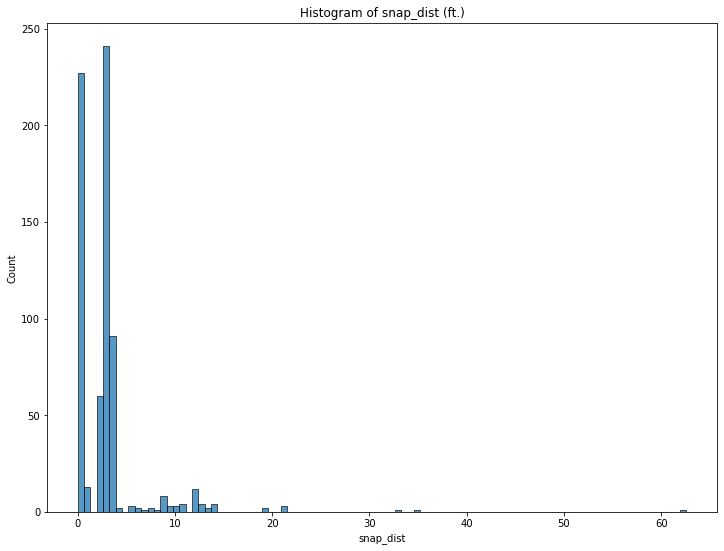

In [1826]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [1827]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
269          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
660          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
762          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
771          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
799          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

    boro_code  line_i physicalid    st_label st_name  full_stree rw_type  \
269         4    55.0      80866   BCH 32 ST    B 32     B 32 ST       1   
660         4   520.0      14606   BCH 67 ST    B 67     B 67 ST       1   
762         4   591.0      14105  ALMEDA AVE  ALMEDA  ALMEDA AVE       1   
771         4   642.0      14297   BCH 61 ST      61   BCH 61 ST       1   
799         4   271.0      80858   BCH 65 ST    B 65     B 65 ST       1   

    rw_type_name st_width frm_lvl_co  
269       Street       32         13  
660       Street       20         13  
762       Street       30         13  
771       Street       30         13  
799       Street       30         13

In [1828]:
updated_points.physicalid.value_counts()

89897     48
168518    22
92055     22
14104     20
14030     17
          ..
14365      1
16224      1
14452      1
168597     1
14122      1
Name: physicalid, Length: 204, dtype: int64

In [1829]:
updated_points.loc[updated_points.physicalid == '89897'].iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
2028          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
4283          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
6631          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
7493          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
8746          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

     boro_code  line_i physicalid   st_label st_name full_stree rw_type  \
2028         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
4283         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
6631         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
7493         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
8746         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   

     rw_type_name st_width frm_lvl_co  
2028       Street       20         13  
4283       Street       20         13  
6631       Street       20         13  
7493       Street       20         13  
8746       Street       20         13

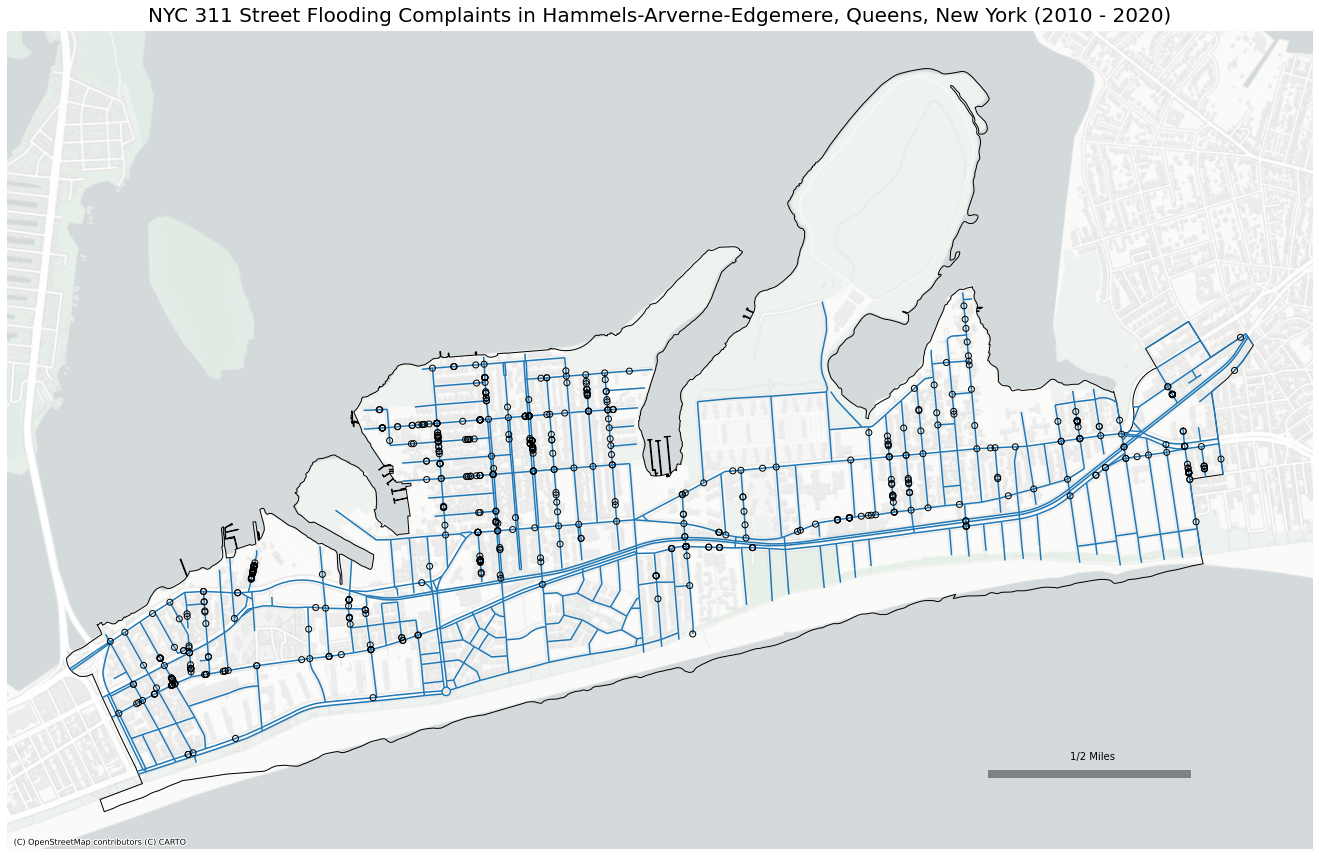

In [1830]:
fig, ax = plt.subplots(figsize=(20,12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, Queens, New York (2010 - 2020)', 
             fontsize=20,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [1831]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [1832]:
gdf_count.head()

physicalid  created_date
0     101236             2
1     102480             1
2     104183            12
3     104184             4
4     104185             1

In [1833]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [1834]:
gdf_count.head()

physicalid  count
0     101236      2
1     102480      1
2     104183     12
3     104184      4
4     104185      1

In [1835]:
streets_clipped.set_geometry('geometry', inplace=True)

In [1836]:
streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [1837]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [1838]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
254       14294            BCH 74 ST            B 74             B 74 ST   
349       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
510      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1020      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
254        1       Street       30         13        13        4  623.015421   
349        1       Street       35         13        13        4  234.071915   
510        1       Street       31         13        13        4  255.930554   
1020       1       Street       24         13        13        4  186.284190   

                                               geometry  \
41    LINESTRING (1041022.181 156864.681, 1040981.69...   
254   LINESTRING (1039173.301 154571.323, 1039121.22...   
349   LINESTRING (1046371.747 155628.532, 1046139.47...   
510   LINESTRING (1041944.905 154892.163, 1041702.46...   
1020  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                               new_geom  
41    POLYGON ((1040941.827 157354.986, 1041021.559 ...  
254   POLYGON ((1039081.367 155188.815, 1039161.087 ...  
349   POLYGON ((1046144.416 155559.902, 1046134.526 ...  
510   POLYGON ((1041715.285 154772.266, 1041689.651 ...  
1020  POLYGON ((1036368.829 153537.091, 1036448.590 ...

In [1839]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 41 to 99111
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 92.2+ KB


In [1840]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [1841]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         204 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [1842]:
streets_with_count.isna().sum()

physicalid        0
st_label          0
st_name           0
full_stree        0
rw_type           0
rw_type_name      0
st_width          0
frm_lvl_co        0
to_lvl_co         0
borocode          0
shape_leng        0
geometry          0
new_geom          0
count           639
dtype: int64

In [1843]:
streets_with_count['count'].fillna(0, inplace=True)

In [1844]:
streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       42         13        13        4  495.233090   
1       Street       30         13        13        4  623.015421   
2       Street       35         13        13        4  234.071915   
3       Street       31         13        13        4  255.930554   
4       Street       24         13        13        4  186.284190   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0

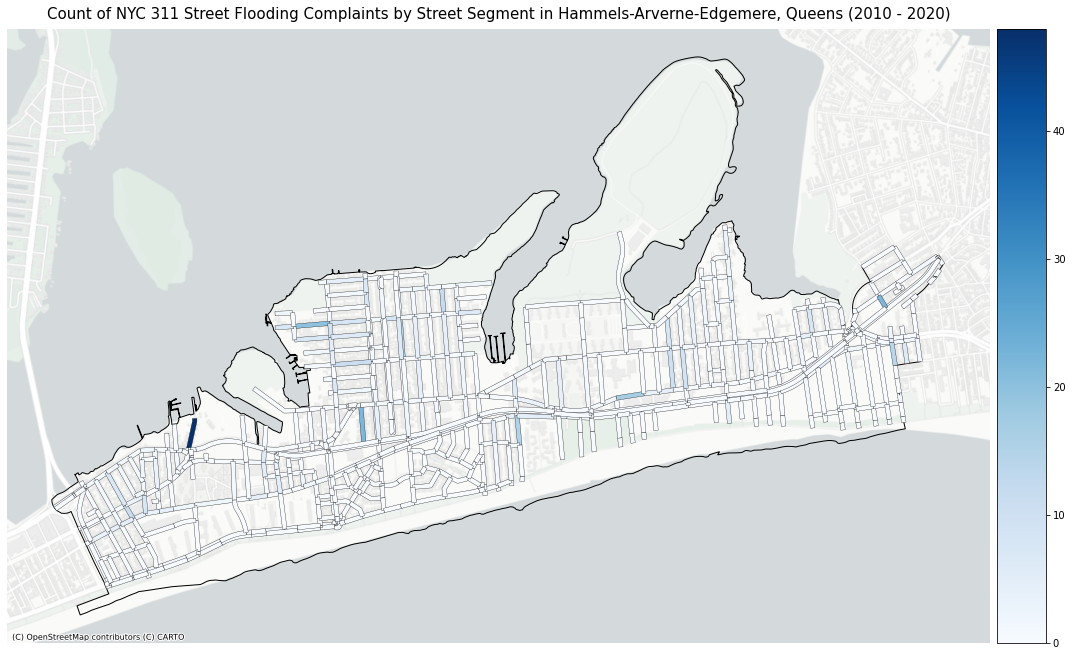

In [1845]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

ax.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

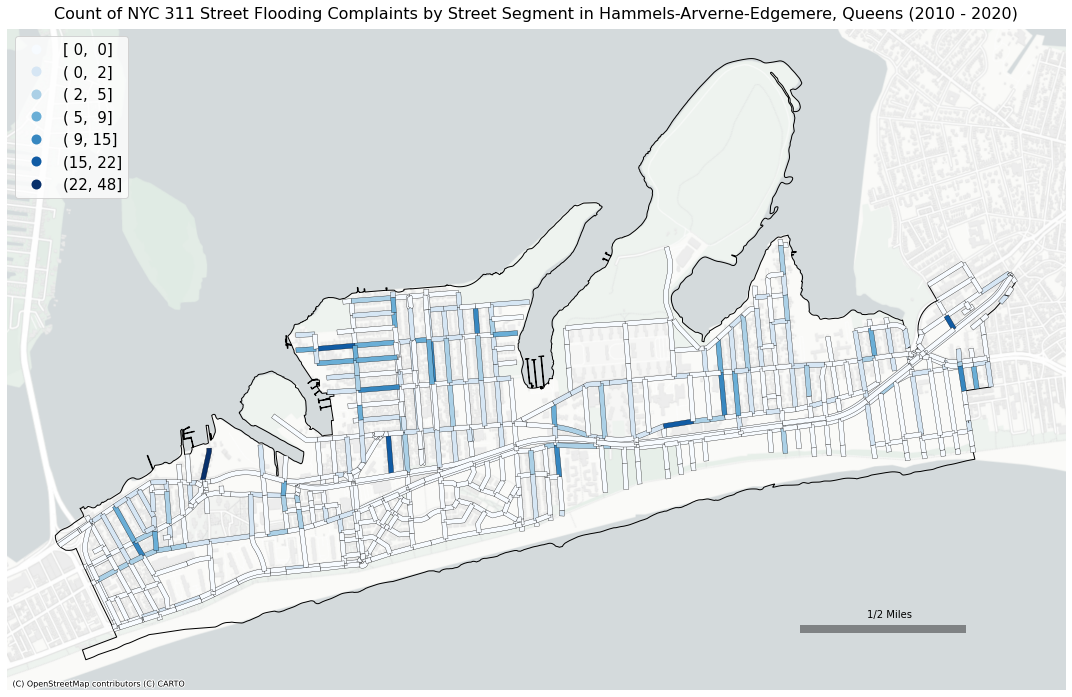

In [1846]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                            'fmt': "{:,.0f}",
                                            'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=16,
             pad=10)

plt.axis('off')
plt.tight_layout()

In [1847]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         843 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [1848]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [1849]:
streets_with_count.length.describe()

count     843.000000
mean      765.594447
std       481.623742
min       160.000025
25%       430.126331
50%       662.259194
75%       955.203538
max      4017.618319
dtype: float64

In [1850]:
streets_with_count.describe()

shape_leng       count
count   843.000000  843.000000
mean    765.594447    0.819692
std     481.623742    2.776426
min     160.000025    0.000000
25%     430.126331    0.000000
50%     662.259194    0.000000
75%     955.203538    0.000000
max    4017.618319   48.000000

In [1851]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       42         13        13        4  1150.466181   
1       Street       30         13        13        4  1406.030841   
2       Street       35         13        13        4   628.143830   
3       Street       31         13        13        4   671.861108   
4       Street       24         13        13        4   532.568379   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0         0.086921  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0         0.000000  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0         0.000000  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0         0.000000  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0         0.000000

In [1852]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   843.000000  843.000000       843.000000
mean    765.594447    0.819692         0.105562
std     481.623742    2.776426         0.346896
min     160.000025    0.000000         0.000000
25%     430.126331    0.000000         0.000000
50%     662.259194    0.000000         0.000000
75%     955.203538    0.000000         0.000000
max    4017.618319   48.000000         4.644650

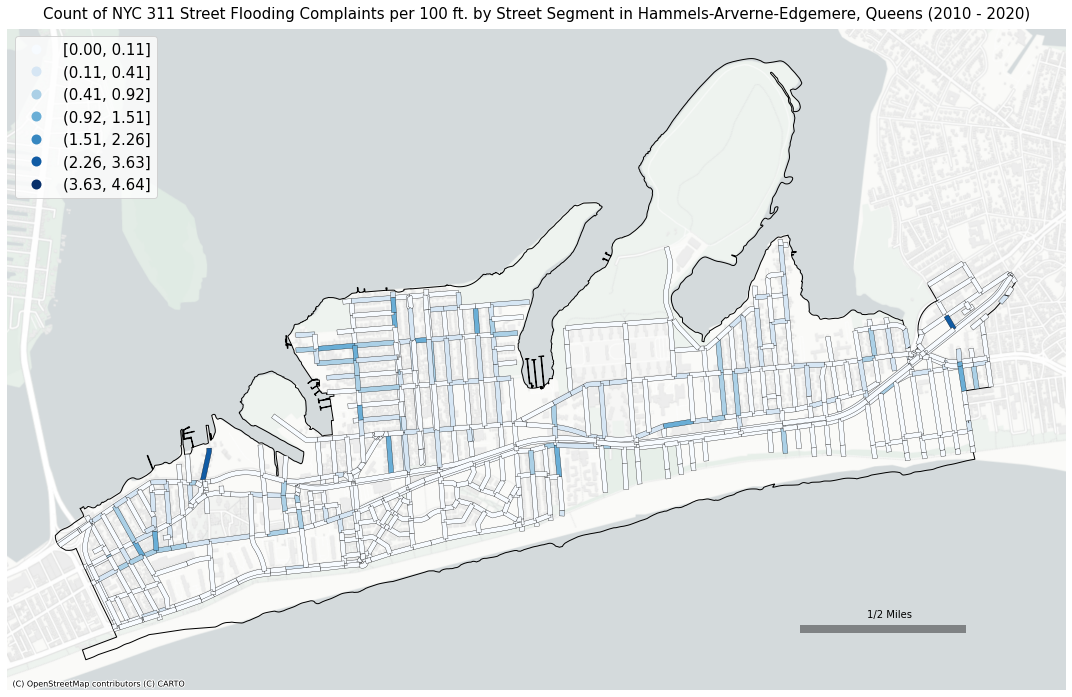

In [1853]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/pres-13.png')

<AxesSubplot:>

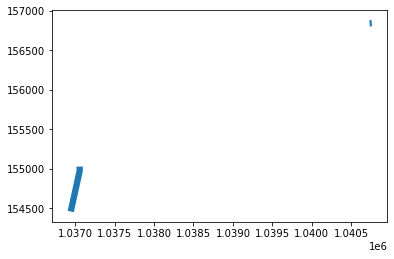

In [1854]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [1855]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid     st_label  st_name   full_stree rw_type rw_type_name  \
141      14099   ALMEDA AVE   ALMEDA   ALMEDA AVE       1       Street   
12       89897    BCH 84 ST     B 84      B 84 ST       1       Street   
721     168518    BCH 32 ST     B 32      B 32 ST       1       Street   
289      14115  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   
294      14110  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
141       52         13        13        4   215.301494   
12        20         13        13        4  1322.346934   
721       30         13        13        4   670.276012   
289       60         13        13        4   216.157649   
294       58         13        13        4   221.032906   

                                              geometry  \
141  LINESTRING (1040758.199 156843.323, 1040743.30...   
12   LINESTRING (1036945.986 154458.262, 1037059.20...   
721  LINESTRING (1049512.805 157017.705, 1049383.00...   
289  LINESTRING (1040269.040 156052.196, 1040255.64...   
294  LINESTRING (1040815.925 156097.308, 1040800.88...   

                                              new_geom  count  count_per_100ft  
141  POLYGON ((1040746.527 156802.249, 1040746.464 ...   10.0         4.644650  
12   POLYGON ((1037019.120 154979.182, 1037018.204 ...   48.0         3.629910  
721  POLYGON ((1049348.570 157217.010, 1049417.444 ...   22.0         3.282230  
289  POLYGON ((1040258.352 156011.379, 1040258.188 ...    7.0         3.238377  
294  POLYGON ((1040804.822 156056.256, 1040790.137 ...    5.0         2.262107

In [1856]:
streets_with_count['count'].sum()

691.0

In [1857]:
streets_with_count['street_and_id'] = streets_with_count['full_stree'] + ', id:' + streets_with_count['physicalid']

streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       42         13        13        4  1150.466181   
1       Street       30         13        13        4  1406.030841   
2       Street       35         13        13        4   628.143830   
3       Street       31         13        13        4   671.861108   
4       Street       24         13        13        4   532.568379   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0         0.086921   
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0         0.000000   
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0         0.000000   
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0         0.000000   
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0         0.000000   

                   street_and_id  
0              B 66 ST, id:92035  
1              B 74 ST, id:14294  
2   ROCKAWAY BEACH AVE, id:14034  
3  ROCKAWAY BEACH AVE, id:154483  
4              B 87 ST, id:92062

In [1858]:
streets_with_count['street_and_id'].is_unique

True

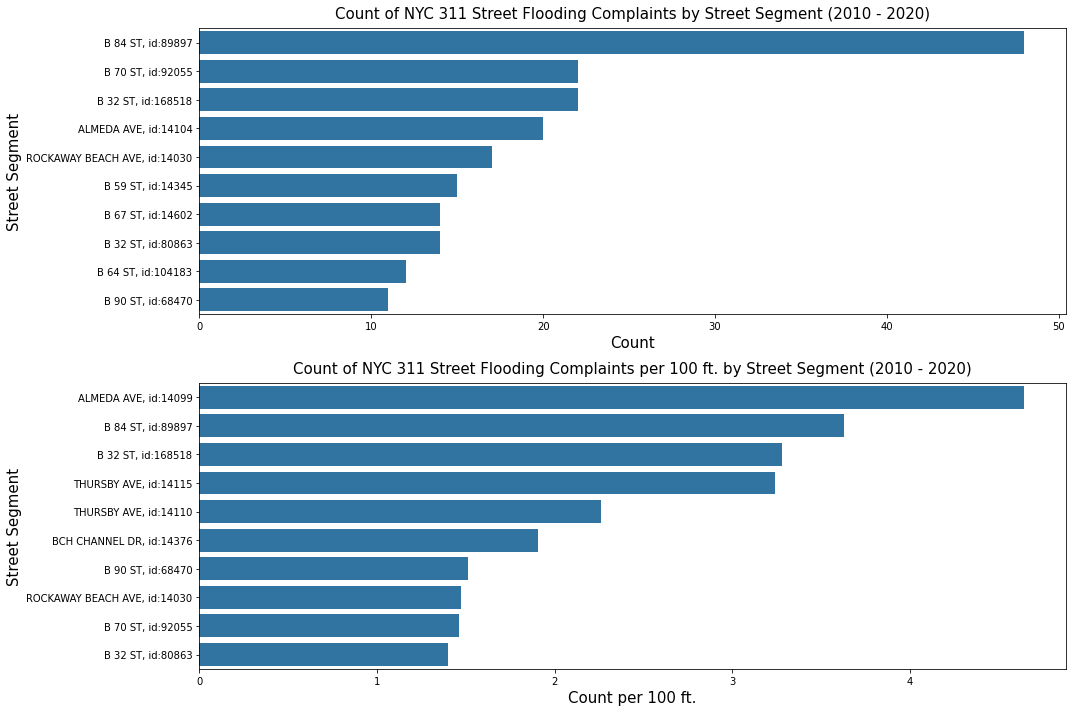

In [1859]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=streets_with_count.sort_values(by='count', ascending=False).head(10),
            y='street_and_id',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='street_and_id',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()

## New Dorp - Midland Beach, Staten Island

In [1860]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [1861]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   
5    19501131  2010-12-30T12:31:00.000  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11210.0                   NaN   
2  Street Flooding (SJ)       10304.0                   NaN   
3  Street Flooding (SJ)       11416.0                   NaN   
4  Street Flooding (SJ)       11357.0                 6 AVE   
5  Street Flooding (SJ)       10312.0                   NaN   

  intersection_street_2  ...   park_borough   latitude  longitude  \
0                   NaN  ...       BROOKLYN  40.616225 -73.954072   
2                   NaN  ...  STATEN ISLAND  40.602264 -74.099007   
3                   NaN  ...         QUEENS  40.688418 -73.842086   
4       CLINTONVILLE ST  ...         QUEENS  40.796721 -73.814709   
5                   NaN  ...  STATEN ISLAND  40.541713 -74.197220   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN   
2    MEDFORD RD       KEUNE CT         FOREST RD  5.008420e+09   
3        102 ST         95 AVE            97 AVE  4.093790e+09   
4           NaN          6 AVE   CLINTONVILLE ST           NaN   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL  5.068490e+09   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 31 columns]

In [1862]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

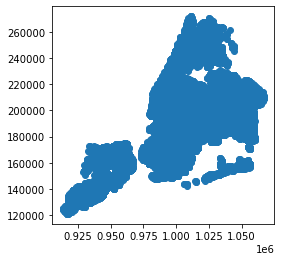

In [1863]:
gdf.plot()

In [1864]:
gdf.shape

(26491, 31)

In [1865]:
gdf.isna().sum()

unique_key                            0
created_date                          0
closed_date                           2
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
incident_zip                          0
intersection_street_1             17250
intersection_street_2             17250
address_type                          0
city                                  0
status                                0
resolution_description                7
resolution_action_updated_date        0
community_board                       0
borough                               0
x_coordinate_state_plane              0
y_coordinate_state_plane              0
open_data_channel_type                0
park_facility_name                    0
park_borough                          0
latitude                              0
longitude                             0
location                              0


In [1866]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [1867]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
37     19627927  2011-01-18T13:41:00.000  2011-01-18T17:00:00.000    DEP   
266    19792418  2011-02-08T15:36:00.000  2011-02-09T08:55:00.000    DEP   
495    46684378  2020-06-29T19:55:00.000  2020-06-30T11:20:00.000    DEP   
662    48160150  2020-11-15T21:07:00.000  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11210.0                   NaN   
37   Street Flooding (SJ)       11230.0                   NaN   
266  Street Flooding (SJ)       11230.0                   NaN   
495  Street Flooding (SJ)       11230.0                   NaN   
662  Street Flooding (SJ)       11230.0            BAY AVENUE   

    intersection_street_2  ...           bbl                       geometry  \
0                     NaN  ...           NaN  POINT (997001.000 163787.000)   
37                    NaN  ...  3.067250e+09  POINT (995149.000 165773.000)   
266                   NaN  ...  3.065280e+09  POINT (993187.000 166340.000)   
495                   NaN  ...  3.067170e+09  POINT (995003.000 166819.000)   
662              AVENUE M  ...           NaN  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 39 columns]

In [1868]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [1869]:
ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [1870]:
path = 'data-raw/raw_streets_clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1871]:
streets.shape

(99373, 12)

<AxesSubplot:>

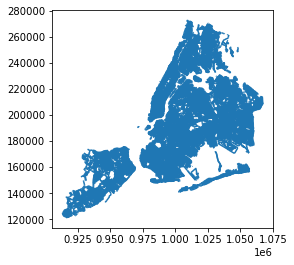

In [1872]:
streets.plot()

In [1873]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99373 entries, 0 to 99372
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99373 non-null  object  
 1   st_label      99373 non-null  object  
 2   st_name       99373 non-null  object  
 3   full_stree    99373 non-null  object  
 4   rw_type       99373 non-null  object  
 5   rw_type_name  99373 non-null  object  
 6   st_width      99373 non-null  object  
 7   frm_lvl_co    99373 non-null  object  
 8   to_lvl_co     99373 non-null  object  
 9   borocode      99373 non-null  object  
 10  shape_leng    99373 non-null  float64 
 11  geometry      99373 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [1874]:
streets.describe()

shape_leng
count  9.937300e+04
mean   3.430782e+02
std    2.619601e+02
min    1.068681e-08
25%    1.953033e+02
50%    2.648316e+02
75%    4.583296e+02
max    1.509366e+04

In [1875]:
streets.geom_type.value_counts()

LineString    99373
dtype: int64

In [1876]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [1877]:
New_Dorp_Midland_Beach = nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach']

New_Dorp_Midland_Beach.head()

ntacode     shape_area county_fips                 ntaname     shape_leng  \
95    SI45  55429451.2194         085  New Dorp-Midland Beach  34336.5206382   

        boro_name boro_code                                           geometry  
95  Staten Island         5  MULTIPOLYGON (((960721.609 147492.642, 960370....

In [1878]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, New_Dorp_Midland_Beach)

<AxesSubplot:>

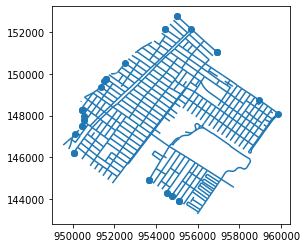

In [1879]:
streets_clipped.plot()

In [1880]:
streets_clipped.geom_type.value_counts()

LineString            737
Point                  32
GeometryCollection      5
MultiLineString         2
dtype: int64

In [1881]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [1882]:
# clipping the school points that only fall within the nta shapes
New_Dorp_Midland_Beach = gpd.clip(gdf, New_Dorp_Midland_Beach)

<AxesSubplot:>

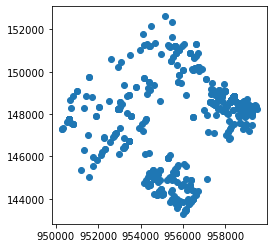

In [1883]:
New_Dorp_Midland_Beach.plot()

In [1884]:
New_Dorp_Midland_Beach.geom_type.value_counts()

Point    755
dtype: int64

# Snap points to lines

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [1885]:
streets_clipped.sindex

rtree.index.Index(bounds=[949549.8247149212, 143281.59894616972, 959897.8481633187, 152760.96722404534], size=737)

In [1886]:
offset = 80

bbox = New_Dorp_Midland_Beach.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
44   953399.0  150703.0  953559.0  150863.0
64   958587.0  147843.0  958747.0  148003.0
184  957349.0  148407.0  957509.0  148567.0
265  957016.0  149566.0  957176.0  149726.0
581  958371.0  148555.0  958531.0  148715.0

In [1887]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

44                    [268]
64      [205, 667, 32, 170]
184    [149, 235, 276, 233]
265    [603, 498, 224, 482]
581    [474, 473, 592, 341]
dtype: object

In [1888]:
hits.shape

(755,)

In [1889]:
tmp = pd.DataFrame(
    # index of points table
    {"pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [1890]:
tmp.head()

pt_idx  line_i
0      44   268.0
1      64   205.0
2      64   667.0
3      64    32.0
4      64   170.0

In [1891]:
tmp.shape

(2625, 2)

In [1892]:
streets_clipped.shape

(737, 12)

In [1893]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
91       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
413      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
555      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
585     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
655      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
91        Street       30         13        13        5  256.539897   
413       Street       30         13        13        5  447.066950   
555       Street       20         13        13        5   40.275747   
585       Street       18         13        13        5  176.145848   
655       Street       30         13        13        5  261.169357   

                                              geometry  
91   LINESTRING (954781.156 151271.724, 954597.833 ...  
413  LINESTRING (952841.921 150886.337, 953221.730 ...  
555  LINESTRING (957558.853 149344.789, 957591.137 ...  
585  LINESTRING (955726.813 147175.642, 955875.554 ...  
655  LINESTRING (953360.096 149917.140, 953173.390 ...

In [1894]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx  line_i physicalid       st_label    st_name     full_stree rw_type  \
0      44   268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE       1   
1      64   205.0      86083     COLONY AVE     COLONY     COLONY AVE       1   
2      64   667.0      85616  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
3      64    32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
4      64   170.0      86084     COLONY AVE     COLONY     COLONY AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       36         13        13        5  729.819880   
1       Street       32         13        13        5  265.009804   
2       Street       30         13        13        5  247.372410   
3       Street       30         13        13        5  249.948154   
4       Street       32         13        13        5  450.985104   

                                            geometry  
0  LINESTRING (953080.920 151067.360, 953677.638 ...  
1  LINESTRING (958667.372 147922.564, 958512.008 ...  
2  LINESTRING (958667.372 147922.564, 958868.434 ...  
3  LINESTRING (958472.487 148079.069, 958667.372 ...  
4  LINESTRING (958931.843 148287.862, 958667.372 ...

In [1895]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(New_Dorp_Midland_Beach.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=New_Dorp_Midland_Beach.crs)

tmp.head()

pt_idx  line_i physicalid       st_label    st_name     full_stree rw_type  \
0      44   268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE       1   
1      64   205.0      86083     COLONY AVE     COLONY     COLONY AVE       1   
2      64   667.0      85616  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
3      64    32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
4      64   170.0      86084     COLONY AVE     COLONY     COLONY AVE       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       36         13        13        5  729.819880   
1       Street       32         13        13        5  265.009804   
2       Street       30         13        13        5  247.372410   
3       Street       30         13        13        5  249.948154   
4       Street       32         13        13        5  450.985104   

                                            geometry  \
0  LINESTRING (953080.920 151067.360, 953677.638 ...   
1  LINESTRING (958667.372 147922.564, 958512.008 ...   
2  LINESTRING (958667.372 147922.564, 958868.434 ...   
3  LINESTRING (958472.487 148079.069, 958667.372 ...   
4  LINESTRING (958931.843 148287.862, 958667.372 ...   

                           point  
0  POINT (953479.000 150783.000)  
1  POINT (958667.000 147923.000)  
2  POINT (958667.000 147923.000)  
3  POINT (958667.000 147923.000)  
4  POINT (958667.000 147923.000)

In [1896]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2625.000000
mean     79.024497
std     111.407917
min       0.000567
25%       0.481531
50%      22.861114
75%      97.963148
max    1119.662091

In [1897]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
2475   26421   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
1657   19221   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
1010    9139   497.0      64050    CLAWSON ST   CLAWSON    CLAWSON ST       1   
2432   26286   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   
2375   25911   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   

     rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
2475       Street       30         13        13        5  608.866647   
1657       Street       30         13        13        5  608.866647   
1010       Street       32         13        13        5  259.287109   
2432       Street       70         13        13        5  305.775123   
2375       Street       70         13        13        5  305.775123   

                                               geometry  \
2475  LINESTRING (953291.900 149648.075, 953790.042 ...   
1657  LINESTRING (953291.900 149648.075, 953790.042 ...   
1010  LINESTRING (952706.317 146911.440, 952557.581 ...   
2432  LINESTRING (956007.528 150101.076, 955827.781 ...   
2375  LINESTRING (956007.528 150101.076, 955827.781 ...   

                              point  snap_dist  
2475  POINT (953790.000 149298.000)   0.000567  
1657  POINT (953790.000 149298.000)   0.000567  
1010  POINT (952706.000 146911.000)   0.007325  
2432  POINT (955828.000 149854.000)   0.007674  
2375  POINT (955828.000 149854.000)   0.007674

In [1898]:
tmp[['snap_dist']].describe()

snap_dist
count  1637.000000
mean     13.733042
std      23.885882
min       0.000567
25%       0.372135
50%       2.637002
75%       4.028307
max      79.689427

In [1899]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
44       268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE       1   
64        32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
184      276.0      52319    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   
265      498.0      64020     HAMDEN AVE     HAMDEN     HAMDEN AVE       1   
581      592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
44           Street       36         13        13        5  729.819880   
64           Street       30         13        13        5  249.948154   
184          Street       54         13        13        5  250.124712   
265          Street       30         13        13        5  427.709979   
581          Street       18         13        13        5  251.356512   

                                                 geometry  \
pt_idx                                                      
44      LINESTRING (953080.920 151067.360, 953677.638 ...   
64      LINESTRING (958472.487 148079.069, 958667.372 ...   
184     LINESTRING (957292.660 148580.797, 957495.822 ...   
265     LINESTRING (957030.669 149691.632, 957389.461 ...   
581     LINESTRING (958315.338 148720.663, 958524.695 ...   

                                point  snap_dist  
pt_idx                                            
44      POINT (953479.000 150783.000)   3.303833  
64      POINT (958667.000 147923.000)   0.107453  
184     POINT (957429.000 148487.000)   3.343146  
265     POINT (957096.000 149646.000)   2.716767  
581     POINT (958451.000 148635.000)   3.728203

In [1900]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
44     POINT (953480.902 150785.701)
64     POINT (958666.933 147922.916)
184    POINT (957427.050 148484.285)
265    POINT (957097.479 149648.279)
581    POINT (958448.937 148631.895)
dtype: geometry

In [1901]:
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
44       268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE       1   
64        32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
184      276.0      52319    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   
265      498.0      64020     HAMDEN AVE     HAMDEN     HAMDEN AVE       1   
581      592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
44           Street       36         13        13        5  729.819880   
64           Street       30         13        13        5  249.948154   
184          Street       54         13        13        5  250.124712   
265          Street       30         13        13        5  427.709979   
581          Street       18         13        13        5  251.356512   

                             geometry                          point  \
pt_idx                                                                 
44      POINT (953480.902 150785.701)  POINT (953479.000 150783.000)   
64      POINT (958666.933 147922.916)  POINT (958667.000 147923.000)   
184     POINT (957427.050 148484.285)  POINT (957429.000 148487.000)   
265     POINT (957097.479 149648.279)  POINT (957096.000 149646.000)   
581     POINT (958448.937 148631.895)  POINT (958451.000 148635.000)   

        snap_dist  
pt_idx             
44       3.303833  
64       0.107453  
184      3.343146  
265      2.716767  
581      3.728203

In [1902]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
44     19628140  2011-01-18T15:57:00.000  2011-01-19T02:45:00.000    DEP   
64     19628220  2011-01-18T16:49:00.000  2011-01-19T02:20:00.000    DEP   
184    19749415  2011-02-02T09:03:00.000  2011-02-02T09:30:00.000    DEP   
265    19792413  2011-02-08T04:02:00.000  2011-02-08T09:00:00.000    DEP   
581    48542262  2020-12-31T09:46:00.000  2020-12-31T13:50:00.000    DEP   

                                agency_name complaint_type  \
44   Department of Environmental Protection          Sewer   
64   Department of Environmental Protection          Sewer   
184  Department of Environmental Protection          Sewer   
265  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
44   Street Flooding (SJ)       10306.0                   NaN   
64   Street Flooding (SJ)       10306.0      HEMPSTEAD AVENUE   
184  Street Flooding (SJ)       10306.0                   NaN   
265  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
44                    NaN  ...    RICHMOND RD      LISBON PL  5.035920e+09   
64          COLONY AVENUE  ...  HEMPSTEAD AVE     COLONY AVE           NaN   
184                   NaN  ...    MORELAND ST     KISWICK ST  5.037350e+09   
265                   NaN  ...    LACONIA AVE     IDLEASE PL  5.037280e+09   
581                   NaN  ...     GRIMSBY ST    FREEBORN ST  5.037960e+09   

                          geometry index_right ntacode county_fips  \
44   POINT (953479.000 150783.000)          95    SI45         085   
64   POINT (958667.000 147923.000)          95    SI45         085   
184  POINT (957429.000 148487.000)          95    SI45         085   
265  POINT (957096.000 149646.000)          95    SI45         085   
581  POINT (958451.000 148635.000)          95    SI45         085   

                    ntaname      boro_name boro_code  
44   New Dorp-Midland Beach  Staten Island         5  
64   New Dorp-Midland Beach  Staten Island         5  
184  New Dorp-Midland Beach  Staten Island         5  
265  New Dorp-Midland Beach  Staten Island         5  
581  New Dorp-Midland Beach  Staten Island         5  

[5 rows x 37 columns]

In [1903]:
New_Dorp_Midland_Beach.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 755 entries, 44 to 27416
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      755 non-null    int64   
 1   created_date                    755 non-null    object  
 2   closed_date                     755 non-null    object  
 3   agency                          755 non-null    object  
 4   agency_name                     755 non-null    object  
 5   complaint_type                  755 non-null    object  
 6   descriptor                      755 non-null    object  
 7   incident_zip                    755 non-null    float64 
 8   intersection_street_1           216 non-null    object  
 9   intersection_street_2           216 non-null    object  
 10  address_type                    755 non-null    object  
 11  city                            755 non-null    object  
 12  status     

In [1904]:
New_Dorp_Midland_Beach.drop(columns=["geometry"], inplace=True)

In [1905]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
44     19628140  2011-01-18T15:57:00.000  2011-01-19T02:45:00.000    DEP   
64     19628220  2011-01-18T16:49:00.000  2011-01-19T02:20:00.000    DEP   
184    19749415  2011-02-02T09:03:00.000  2011-02-02T09:30:00.000    DEP   
265    19792413  2011-02-08T04:02:00.000  2011-02-08T09:00:00.000    DEP   
581    48542262  2020-12-31T09:46:00.000  2020-12-31T13:50:00.000    DEP   

                                agency_name complaint_type  \
44   Department of Environmental Protection          Sewer   
64   Department of Environmental Protection          Sewer   
184  Department of Environmental Protection          Sewer   
265  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
44   Street Flooding (SJ)       10306.0                   NaN   
64   Street Flooding (SJ)       10306.0      HEMPSTEAD AVENUE   
184  Street Flooding (SJ)       10306.0                   NaN   
265  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ...      street_name cross_street_1 cross_street_2  \
44                    NaN  ...      LINCOLN AVE    RICHMOND RD      LISBON PL   
64          COLONY AVENUE  ...              NaN  HEMPSTEAD AVE     COLONY AVE   
184                   NaN  ...      MIDLAND AVE    MORELAND ST     KISWICK ST   
265                   NaN  ...       HAMDEN AVE    LACONIA AVE     IDLEASE PL   
581                   NaN  ...  MAPLETON AVENUE     GRIMSBY ST    FREEBORN ST   

              bbl index_right ntacode county_fips                 ntaname  \
44   5.035920e+09          95    SI45         085  New Dorp-Midland Beach   
64            NaN          95    SI45         085  New Dorp-Midland Beach   
184  5.037350e+09          95    SI45         085  New Dorp-Midland Beach   
265  5.037280e+09          95    SI45         085  New Dorp-Midland Beach   
581  5.037960e+09          95    SI45         085  New Dorp-Midland Beach   

         boro_name boro_code  
44   Staten Island         5  
64   Staten Island         5  
184  Staten Island         5  
265  Staten Island         5  
581  Staten Island         5  

[5 rows x 36 columns]

In [1906]:
snapped.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
44       268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE       1   
64        32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE       1   
184      276.0      52319    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   
265      498.0      64020     HAMDEN AVE     HAMDEN     HAMDEN AVE       1   
581      592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
44           Street       36         13        13        5  729.819880   
64           Street       30         13        13        5  249.948154   
184          Street       54         13        13        5  250.124712   
265          Street       30         13        13        5  427.709979   
581          Street       18         13        13        5  251.356512   

                             geometry                          point  \
pt_idx                                                                 
44      POINT (953480.902 150785.701)  POINT (953479.000 150783.000)   
64      POINT (958666.933 147922.916)  POINT (958667.000 147923.000)   
184     POINT (957427.050 148484.285)  POINT (957429.000 148487.000)   
265     POINT (957097.479 149648.279)  POINT (957096.000 149646.000)   
581     POINT (958448.937 148631.895)  POINT (958451.000 148635.000)   

        snap_dist  
pt_idx             
44       3.303833  
64       0.107453  
184      3.343146  
265      2.716767  
581      3.728203

In [1907]:
# Join back to the original points:
updated_points = New_Dorp_Midland_Beach.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
44     19628140  2011-01-18T15:57:00.000  2011-01-19T02:45:00.000    DEP   
64     19628220  2011-01-18T16:49:00.000  2011-01-19T02:20:00.000    DEP   
184    19749415  2011-02-02T09:03:00.000  2011-02-02T09:30:00.000    DEP   
265    19792413  2011-02-08T04:02:00.000  2011-02-08T09:00:00.000    DEP   
581    48542262  2020-12-31T09:46:00.000  2020-12-31T13:50:00.000    DEP   

                                agency_name complaint_type  \
44   Department of Environmental Protection          Sewer   
64   Department of Environmental Protection          Sewer   
184  Department of Environmental Protection          Sewer   
265  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
44   Street Flooding (SJ)       10306.0                   NaN   
64   Street Flooding (SJ)       10306.0      HEMPSTEAD AVENUE   
184  Street Flooding (SJ)       10306.0                   NaN   
265  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
44                    NaN  ...       1       Street       36         13   
64          COLONY AVENUE  ...       1       Street       30         13   
184                   NaN  ...       1       Street       54         13   
265                   NaN  ...       1       Street       30         13   
581                   NaN  ...       1       Street       18         13   

    to_lvl_co borocode  shape_leng                       geometry  \
44         13        5  729.819880  POINT (953480.902 150785.701)   
64         13        5  249.948154  POINT (958666.933 147922.916)   
184        13        5  250.124712  POINT (957427.050 148484.285)   
265        13        5  427.709979  POINT (957097.479 149648.279)   
581        13        5  251.356512  POINT (958448.937 148631.895)   

                             point snap_dist  
44   POINT (953479.000 150783.000)  3.303833  
64   POINT (958667.000 147923.000)  0.107453  
184  POINT (957429.000 148487.000)  3.343146  
265  POINT (957096.000 149646.000)  2.716767  
581  POINT (958451.000 148635.000)  3.728203  

[5 rows x 51 columns]

In [1908]:
updated_points.geometry.isna().sum()

5

In [1909]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
44     19628140  2011-01-18T15:57:00.000  2011-01-19T02:45:00.000    DEP   
64     19628220  2011-01-18T16:49:00.000  2011-01-19T02:20:00.000    DEP   
184    19749415  2011-02-02T09:03:00.000  2011-02-02T09:30:00.000    DEP   
265    19792413  2011-02-08T04:02:00.000  2011-02-08T09:00:00.000    DEP   
581    48542262  2020-12-31T09:46:00.000  2020-12-31T13:50:00.000    DEP   

                                agency_name complaint_type  \
44   Department of Environmental Protection          Sewer   
64   Department of Environmental Protection          Sewer   
184  Department of Environmental Protection          Sewer   
265  Department of Environmental Protection          Sewer   
581  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
44   Street Flooding (SJ)       10306.0                   NaN   
64   Street Flooding (SJ)       10306.0      HEMPSTEAD AVENUE   
184  Street Flooding (SJ)       10306.0                   NaN   
265  Street Flooding (SJ)       10306.0                   NaN   
581  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
44                    NaN  ...       1       Street       36         13   
64          COLONY AVENUE  ...       1       Street       30         13   
184                   NaN  ...       1       Street       54         13   
265                   NaN  ...       1       Street       30         13   
581                   NaN  ...       1       Street       18         13   

    to_lvl_co borocode  shape_leng                       geometry  \
44         13        5  729.819880  POINT (953480.902 150785.701)   
64         13        5  249.948154  POINT (958666.933 147922.916)   
184        13        5  250.124712  POINT (957427.050 148484.285)   
265        13        5  427.709979  POINT (957097.479 149648.279)   
581        13        5  251.356512  POINT (958448.937 148631.895)   

                             point snap_dist  
44   POINT (953479.000 150783.000)  3.303833  
64   POINT (958667.000 147923.000)  0.107453  
184  POINT (957429.000 148487.000)  3.343146  
265  POINT (957096.000 149646.000)  2.716767  
581  POINT (958451.000 148635.000)  3.728203  

[5 rows x 51 columns]

In [1910]:
updated_points.shape

(750, 51)

In [1911]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
19221    39258388  2018-05-22T12:53:00.000  2018-05-23T09:15:00.000    DEP   
26421    21377770  2011-09-06T16:37:00.000  2011-09-07T14:30:00.000    DEP   
9139     27165829  2014-01-16T07:30:00.000  2014-01-17T09:30:00.000    DEP   
26286    21125790  2011-08-28T12:02:00.000  2011-08-28T16:30:00.000    DEP   
25911    21034224  2011-08-14T05:49:00.000  2011-08-14T14:15:00.000    DEP   

                                  agency_name complaint_type  \
19221  Department of Environmental Protection          Sewer   
26421  Department of Environmental Protection          Sewer   
9139   Department of Environmental Protection          Sewer   
26286  Department of Environmental Protection          Sewer   
25911  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
19221  Street Flooding (SJ)       10306.0         EDISON STREET   
26421  Street Flooding (SJ)       10306.0       BANCROFT AVENUE   
9139   Street Flooding (SJ)       10306.0           ROSS AVENUE   
26286  Street Flooding (SJ)       10306.0        MIDLAND AVENUE   
25911  Street Flooding (SJ)       10306.0       HYLAN BOULEVARD   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
19221       BANCROFT AVENUE  ...       1       Street       30         13   
26421         EDISON STREET  ...       1       Street       30         13   
9139         CLAWSON STREET  ...       1       Street       32         13   
26286       HYLAN BOULEVARD  ...       1       Street       70         13   
25911        MIDLAND AVENUE  ...       1       Street       70         13   

      to_lvl_co borocode  shape_leng                       geometry  \
19221        13        5  608.866647  POINT (953790.000 149298.000)   
26421        13        5  608.866647  POINT (953790.000 149298.000)   
9139         13        5  259.287109  POINT (952706.006 146910.996)   
26286        13        5  305.775123  POINT (955827.994 149854.005)   
25911        13        5  305.775123  POINT (955827.994 149854.005)   

                               point snap_dist  
19221  POINT (953790.000 149298.000)  0.000567  
26421  POINT (953790.000 149298.000)  0.000567  
9139   POINT (952706.000 146911.000)  0.007325  
26286  POINT (955828.000 149854.000)  0.007674  
25911  POINT (955828.000 149854.000)  0.007674  

[5 rows x 51 columns]

In [1912]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
13696    32698429  2016-02-16T15:09:00.000  2016-02-18T09:30:00.000    DEP   
27076    22410047  2011-12-28T00:00:00.000  2011-12-28T11:30:00.000    DEP   
26993    22267856  2011-12-06T23:42:00.000  2011-12-07T09:30:00.000    DEP   
16315    36112767  2017-05-05T13:09:00.000  2017-05-05T19:30:00.000    DEP   
24916    45618020  2020-02-14T13:54:00.000  2020-02-14T17:35:00.000    DEP   

                                  agency_name complaint_type  \
13696  Department of Environmental Protection          Sewer   
27076  Department of Environmental Protection          Sewer   
26993  Department of Environmental Protection          Sewer   
16315  Department of Environmental Protection          Sewer   
24916  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
13696  Street Flooding (SJ)       10306.0                   NaN   
27076  Street Flooding (SJ)       10306.0                   NaN   
26993  Street Flooding (SJ)       10306.0                   NaN   
16315  Street Flooding (SJ)       10306.0                   NaN   
24916  Street Flooding (SJ)       10306.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
13696                   NaN  ...       1       Street       30         13   
27076                   NaN  ...       1       Street       26         13   
26993                   NaN  ...       1       Street       26         13   
16315                   NaN  ...       1       Street       34         13   
24916                   NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                       geometry  \
13696        13        5  172.488718  POINT (950303.664 147302.727)   
27076        13        5  415.175106  POINT (951590.059 149773.632)   
26993        13        5  415.175106  POINT (951590.059 149773.632)   
16315        13        5  877.651987  POINT (954455.655 152137.781)   
24916        13        5  380.747823  POINT (959115.406 147207.210)   

                               point  snap_dist  
13696  POINT (950345.000 147352.000)  64.315603  
27076  POINT (951564.000 149728.000)  52.548002  
26993  POINT (951564.000 149728.000)  52.548002  
16315  POINT (954484.000 152178.000)  49.203561  
24916  POINT (959133.000 147195.000)  21.415827  

[5 rows x 51 columns]

In [1913]:
updated_points[['snap_dist']].describe()

snap_dist
count  750.000000
mean     2.829254
std      4.680600
min      0.000567
25%      0.471728
50%      2.802099
75%      3.255358
max     64.315603

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

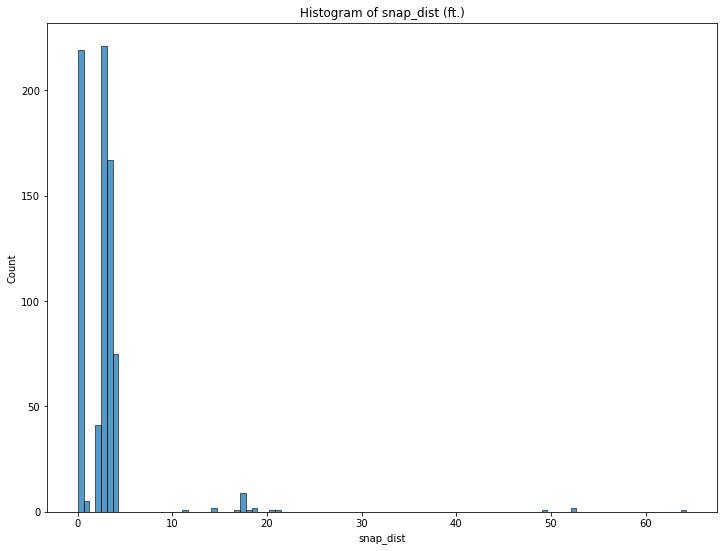

In [1914]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [1915]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
44            95    SI45         085  New Dorp-Midland Beach  Staten Island   
64            95    SI45         085  New Dorp-Midland Beach  Staten Island   
184           95    SI45         085  New Dorp-Midland Beach  Staten Island   
265           95    SI45         085  New Dorp-Midland Beach  Staten Island   
581           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid       st_label    st_name     full_stree  \
44          5   268.0      52052    LINCOLN AVE    LINCOLN    LINCOLN AVE   
64          5    32.0      85615  HEMPSTEAD AVE  HEMPSTEAD  HEMPSTEAD AVE   
184         5   276.0      52319    MIDLAND AVE    MIDLAND    MIDLAND AVE   
265         5   498.0      64020     HAMDEN AVE     HAMDEN     HAMDEN AVE   
581         5   592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE   

    rw_type rw_type_name st_width frm_lvl_co  
44        1       Street       36         13  
64        1       Street       30         13  
184       1       Street       54         13  
265       1       Street       30         13  
581       1       Street       18         13

In [1916]:
updated_points.physicalid.value_counts()

76941    112
52067     51
63880     40
76093     31
85564     27
        ... 
90565      1
85844      1
52151      1
54003      1
63887      1
Name: physicalid, Length: 187, dtype: int64

In [1917]:
updated_points.loc[updated_points.physicalid == '76941'].iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
631           95    SI45         085  New Dorp-Midland Beach  Staten Island   
697           95    SI45         085  New Dorp-Midland Beach  Staten Island   
761           95    SI45         085  New Dorp-Midland Beach  Staten Island   
763           95    SI45         085  New Dorp-Midland Beach  Staten Island   
768           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid    st_label  st_name  full_stree rw_type  \
631         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
697         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
761         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
763         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
768         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
631       Street       22         13  
697       Street       22         13  
761       Street       22         13  
763       Street       22         13  
768       Street       22         13

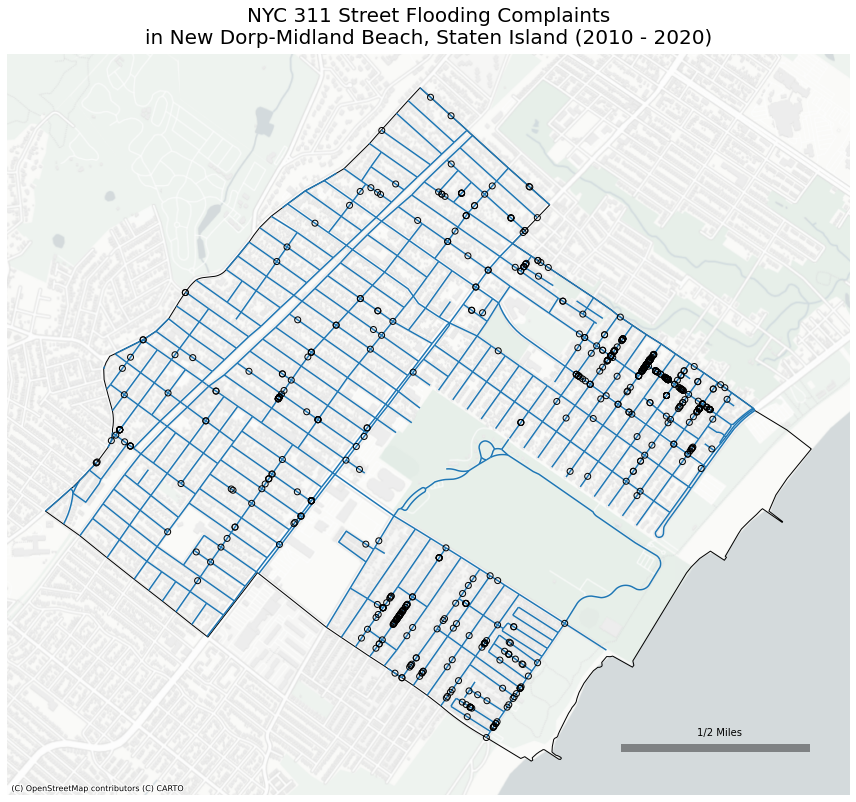

In [1918]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [1919]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [1920]:
gdf_count.head()

physicalid  created_date
0     100411             1
1     100451             1
2     100452             2
3     100795             1
4     100822             8

In [1921]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [1922]:
gdf_count.head()

physicalid  count
0     100411      1
1     100451      1
2     100452      2
3     100795      1
4     100822      8

In [1923]:
streets_clipped.set_geometry('geometry', inplace=True)

In [1924]:
streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [1925]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [1926]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
91       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
413      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
555      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
585     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
655      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
91        Street       30         13        13        5  256.539897   
413       Street       30         13        13        5  447.066950   
555       Street       20         13        13        5   40.275747   
585       Street       18         13        13        5  176.145848   
655       Street       30         13        13        5  261.169357   

                                              geometry  \
91   LINESTRING (954781.156 151271.724, 954597.833 ...   
413  LINESTRING (952841.921 150886.337, 953221.730 ...   
555  LINESTRING (957558.853 149344.789, 957591.137 ...   
585  LINESTRING (955726.813 147175.642, 955875.554 ...   
655  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                              new_geom  
91   POLYGON ((954625.814 151063.681, 954569.851 15...  
413  POLYGON ((953242.830 150684.493, 953200.630 15...  
555  POLYGON ((957615.053 149352.770, 957567.220 14...  
585  POLYGON ((955854.127 147303.776, 955896.981 14...  
655  POLYGON ((953201.360 149705.923, 953145.420 14...

In [1927]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 91 to 99354
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 80.6+ KB


In [1928]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [1929]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         187 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [1930]:
streets_with_count['count'].fillna(0, inplace=True)

In [1931]:
streets_with_count[['count']].isna().sum()

count    0
dtype: int64

In [1932]:
streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       30         13        13        5  256.539897   
1       30         13        13        5  447.066950   
2       20         13        13        5   40.275747   
3       18         13        13        5  176.145848   
4       30         13        13        5  261.169357   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0

In [1933]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
252      63880      WEED AVE      WEED      WEED AVE       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
148       22         13        13        5  372.786118   
574       38         13        13        5  549.294789   
252       32         13        13        5  766.375339   
473       25         13        13        5  248.849478   
118       32         13        13        5  454.064519   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
252  LINESTRING (954903.616 145334.160, 954463.348 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  112.0  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0  
252  POLYGON ((954496.089 144683.889, 954430.607 14...   40.0  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0

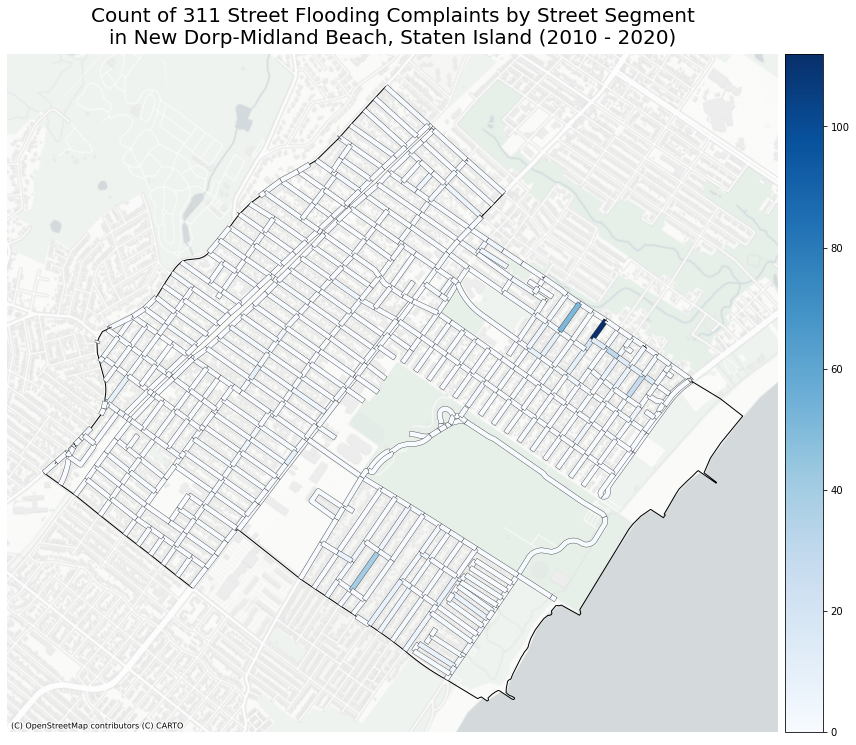

In [1934]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of 311 Street Flooding Complaints by Street Segment\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

ax.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

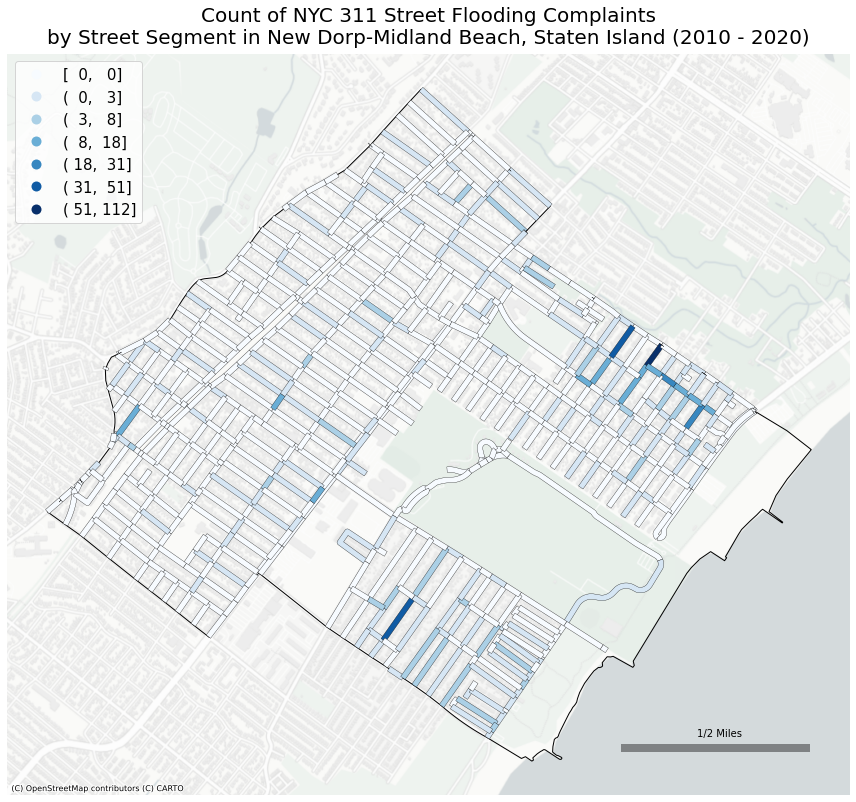

In [1935]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

ax.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [1936]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         737 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [1937]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [1938]:
streets_with_count.length.describe()

count     737.000000
mean      852.519540
std       464.511570
min       160.000006
25%       657.049620
50%       689.688260
75%      1084.789133
max      5557.842467
dtype: float64

In [1939]:
streets_with_count.describe()

shape_leng       count
count   737.000000  737.000000
mean    852.519540    1.017639
std     464.511570    5.259666
min     160.000006    0.000000
25%     657.049620    0.000000
50%     689.688260    0.000000
75%    1084.789133    1.000000
max    5557.842467  112.000000

In [1940]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       30         13        13        5   673.079794   
1       30         13        13        5  1054.133640   
2       20         13        13        5   240.551494   
3       18         13        13        5   512.291697   
4       30         13        13        5   682.338714   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0              0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0              0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0              0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0              0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0              0.0

In [1941]:
streets_with_count.describe()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


shape_leng       count  count_per_100ft
count   737.000000  737.000000       737.000000
mean    852.519540    1.017639         0.118403
std     464.511570    5.259666         0.576790
min     160.000006    0.000000         0.000000
25%     657.049620    0.000000         0.000000
50%     689.688260    0.000000         0.000000
75%    1084.789133    1.000000         0.052211
max    5557.842467  112.000000        12.367870

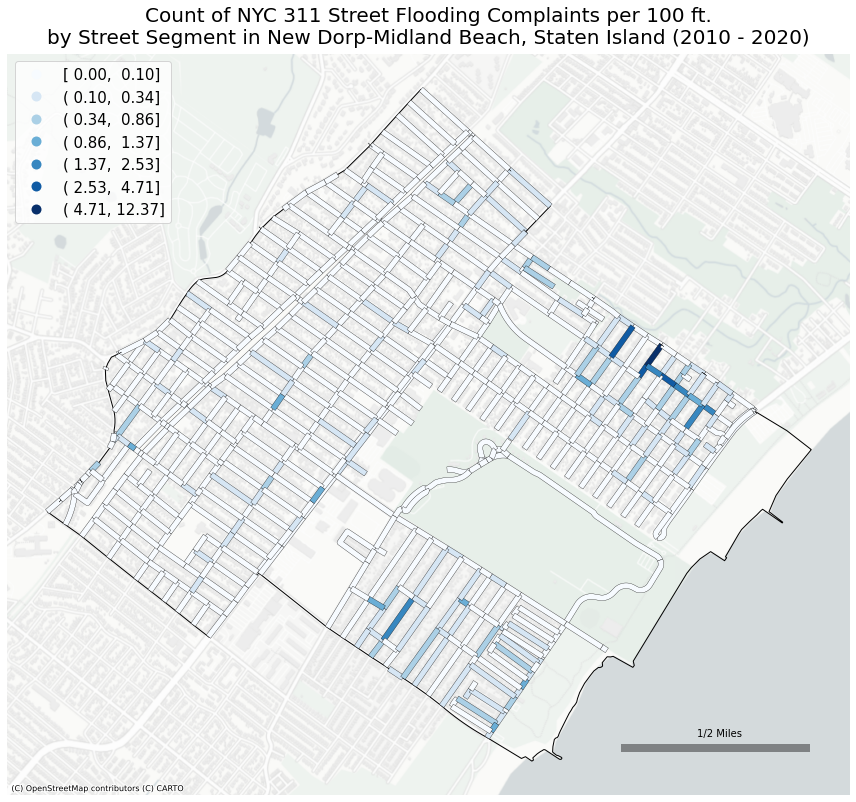

In [1942]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft.\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/pres-14.png')

<AxesSubplot:>

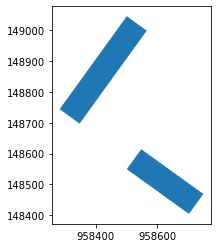

In [1943]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [1944]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
52       76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
148       22         13        13        5   905.572235   
473       25         13        13        5   657.698955   
574       38         13        13        5  1258.589579   
52        32         13        13        5   554.966971   
118       32         13        13        5  1068.129038   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
52   LINESTRING (958315.338 148720.663, 958202.776 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  count_per_100ft  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  112.0        12.367870  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0         4.713403  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0         4.052155  
52   POLYGON ((958235.642 148535.600, 958169.910 14...   18.0         3.243436  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0         2.527784

In [1945]:
streets_with_count['count'].sum()

750.0

In [1946]:
streets_with_count['street_and_id'] = streets_with_count['full_stree'] + ', id:' + streets_with_count['physicalid']

streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       30         13        13        5   673.079794   
1       30         13        13        5  1054.133640   
2       20         13        13        5   240.551494   
3       18         13        13        5   512.291697   
4       30         13        13        5   682.338714   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0              0.0   
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0              0.0   
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0              0.0   
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0              0.0   
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0              0.0   

               street_and_id  
0  N  RAILROAD AVE, id:63908  
1      FREMONT AVE, id:98840  
2       HAMDEN AVE, id:64022  
3      SANCHEZ DR, id:169350  
4  N  RAILROAD AVE, id:63915

In [1947]:
streets_with_count['street_and_id'].is_unique

True

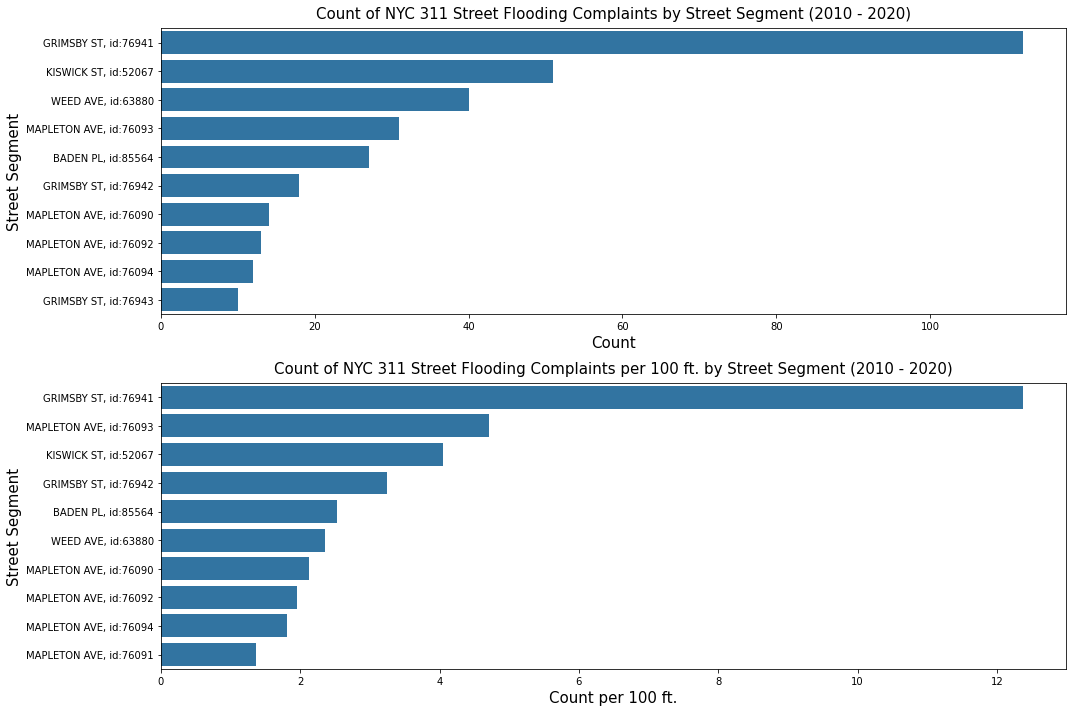

In [1948]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=streets_with_count.sort_values(by='count', ascending=False).head(10),
            y='street_and_id',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='street_and_id',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()